This is a script that is focus on **Personal Financial/Investment Planning**.

## **Data Format Visualization**
- to check whether there is data for our selected period.

In [ ]:
import yfinance as yf
tickers = ["QQQ", "VOO"]
df = yf.download(tickers, start="2010-10-01", end="2025-09-30") #["Close"]
df

/tmp/ipython-input-2640392889.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2010-10-01", end="2025-09-30") #["Close"]
[*********************100%***********************]  2 of 2 completed


Price            Close                    High                     Low  \
Ticker             QQQ         VOO         QQQ         VOO         QQQ   
Date                                                                     
2010-10-01   42.958214   80.010101   43.414004   80.346280   42.756615   
2010-10-04   42.493683   79.337776   42.993299   80.422716   42.248258   
2010-10-05   43.527962   81.079765   43.615612   81.140884   42.949459   
2010-10-06   43.151043   80.942230   43.571772   81.202000   42.870557   
2010-10-07   43.308834   80.896408   43.422783   81.370114   42.949461   
...                ...         ...         ...         ...         ...   
2025-09-23  598.200012  609.796021  602.570007  613.505444  596.979980   
2025-09-24  596.099976  607.761902  599.900024  610.992653  593.359985   
2025-09-25  593.530029  604.860229  595.119995  606.196374  588.500000   
2025-09-26  595.969971  608.419983  596.299988  608.958482  591.059998   
2025-09-29  598.729980  610.130005  602.049988  611.679993  597.409973   

Price                         Open                Volume            
Ticker             VOO         QQQ         VOO       QQQ       VOO  
Date                                                                
2010-10-01   79.582242   43.370179   80.285156  77675400     17100  
2010-10-04   79.078006   42.835525   80.422716  71359900     88700  
2010-10-05   80.086513   42.975753   80.239318  99301300     19850  
2010-10-06   80.697738   43.475354   81.079757  81831200    276900  
2010-10-07   80.468548   43.396485   81.370114  75693300     49900  
...                ...         ...         ...       ...       ...  
2025-09-23  608.599491  602.369995  612.957024  64635500  10753000  
2025-09-24  606.455640  599.580017  610.882981  49850300  23787300  
2025-09-25  601.629418  592.200012  604.890112  70920200   6965700  
2025-09-26  604.840255  594.349976  606.296113  54337400   6438600  
2025-09-29  608.479980  599.109985  610.789978  48332900   5658800  

[3771 rows x 10 columns]

## **15Y Quantitative Analysis (CAGR, Stdev, Sharpe, Max DD)**

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

ANALYSIS_TICKERS = ['QQQ']
BENCHMARK_TICKER = 'VOO'
tickers_to_download = ANALYSIS_TICKERS + [BENCHMARK_TICKER, '^TNX']

start_year = 2010
end_year = 2025
start_date_format = "%Y-10-01"
end_date_format = "%Y-09-30"
annual_returns = []

download_end_year = max(end_year + 1, 2026)

all_data = yf.download(
    tickers_to_download,
    start=datetime.strptime(f"{start_year}-10-01", start_date_format).strftime('%Y-%m-%d'),
    end=datetime.strptime(f"{download_end_year}-09-30", end_date_format).strftime('%Y-%m-%d'),
    progress=False
)

all_data = all_data.sort_index()

tnx_data = all_data['Close']['^TNX'].dropna()
risk_free_rate = tnx_data.mean() / 100
print(f"Calculated Risk-Free Rate (Annual): {risk_free_rate*100:.2f}%\n")

def find_nearest_trading_day(target_date, data_index, direction='nearest'):
    target_date = pd.to_datetime(target_date)

    if direction == 'before':
        available_dates = data_index[data_index <= target_date]
        return available_dates[-1] if len(available_dates) > 0 else data_index[0]

    elif direction == 'after':
        available_dates = data_index[data_index >= target_date]
        return available_dates[0] if len(available_dates) > 0 else data_index[-1]

    else:
        differences = abs(data_index - target_date)
        min_diff_idx = differences.argmin()
        return data_index[min_diff_idx]

cumulative_values = {ticker: 100 for ticker in ANALYSIS_TICKERS + [BENCHMARK_TICKER]}

for year in range(start_year, end_year):
    period_start = f"{year}-10-01"
    period_end = f"{year+1}-09-30"

    if year + 1 > end_year:
        break

    row = {"Year": f"Oct {year} - Sep {year+1}"}

    for ticker in ANALYSIS_TICKERS + [BENCHMARK_TICKER]:
        try:
            ticker_data_index = all_data['Open'][ticker].dropna().index
            if len(ticker_data_index) == 0:
                raise IndexError(f"No data available for {ticker}")

            start_trading_date = find_nearest_trading_day(period_start, ticker_data_index, 'after')
            start_price = all_data['Open'][ticker].loc[start_trading_date]
            end_trading_date = find_nearest_trading_day(period_end, ticker_data_index, 'before')
            end_price = all_data['Close'][ticker].loc[end_trading_date]

            start_price = float(start_price.iloc[0]) if hasattr(start_price, 'iloc') else float(start_price)
            end_price = float(end_price.iloc[0]) if hasattr(end_price, 'iloc') else float(end_price)

            stock_return = (end_price / start_price - 1) * 100

            row[f"{ticker} Open"] = round(start_price, 2)
            row[f"{ticker} Open Date"] = start_trading_date.strftime('%Y-%m-%d')
            row[f"{ticker} Close"] = round(end_price, 2)
            row[f"{ticker} Close Date"] = end_trading_date.strftime('%Y-%m-%d')
            row[f"{ticker} Return (%)"] = round(stock_return, 2)

            cumulative_values[ticker] *= (1 + stock_return / 100)

        except (IndexError, KeyError):
            row[f"{ticker} Open"] = np.nan
            row[f"{ticker} Open Date"] = np.nan
            row[f"{ticker} Close"] = np.nan
            row[f"{ticker} Close Date"] = np.nan
            row[f"{ticker} Return (%)"] = np.nan
            continue

    annual_returns.append(row)

annual_df = pd.DataFrame(annual_returns)

def create_summary_table(period_df, all_daily_data, risk_free_rate):
    summary_data = {
        'Average Return (%)': {},
        'Annualized Return (%)': {},
        'Standard Deviation (%)': {},
        'Cumulative Return (%)': {},
        'Beta': {},
        'Sharpe Ratio': {},
        'R-squared (%)': {},
        'Max Drawdown (%)': {}
    }

    start_date = period_df.iloc[0]['Year'].split(' ')[1] + '-10-01'
    end_date = period_df.iloc[-1]['Year'].split(' ')[-1] + '-09-30'

    period_daily_data = all_daily_data['Close'].loc[start_date:end_date]
    daily_returns = period_daily_data[ANALYSIS_TICKERS + [BENCHMARK_TICKER]].pct_change().dropna()
    daily_risk_free_rate = risk_free_rate / 252

    def max_drawdown(prices):
        if prices.empty:
            return np.nan
        cumulative_returns = (1 + prices.pct_change().fillna(0)).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        return drawdown.min() * 100

    for ticker in ANALYSIS_TICKERS + [BENCHMARK_TICKER]:
        annual_returns_decimal = period_df[f"{ticker} Return (%)"].dropna() / 100
        summary_data['Average Return (%)'][f"{ticker} Return (%)"] = annual_returns_decimal.mean() * 100
        cumulative_return_decimal = np.prod(1 + annual_returns_decimal) - 1
        summary_data['Cumulative Return (%)'][f"{ticker} Return (%)"] = cumulative_return_decimal * 100

        ticker_daily = daily_returns[ticker].dropna()
        if len(ticker_daily) > 0:
            cumulative_growth = (1 + ticker_daily).prod()
            annualized_return = (cumulative_growth ** (252 / len(ticker_daily)) - 1) * 100
            annualized_volatility = ticker_daily.std() * np.sqrt(252) * 100
        else:
            annualized_return = np.nan
            annualized_volatility = np.nan
        summary_data['Annualized Return (%)'][f"{ticker} Return (%)"] = annualized_return
        summary_data['Standard Deviation (%)'][f"{ticker} Return (%)"] = annualized_volatility

        # Beta, R-squared, Sharpe Ratio
        if ticker != BENCHMARK_TICKER:
            covariance = daily_returns[ticker].cov(daily_returns[BENCHMARK_TICKER])
            voo_variance = daily_returns[BENCHMARK_TICKER].var()
            beta = covariance / voo_variance
            summary_data['Beta'][f"{ticker} Return (%)"] = beta

            correlation = daily_returns[ticker].corr(daily_returns[BENCHMARK_TICKER])
            r_squared = correlation ** 2 * 100
            summary_data['R-squared (%)'][f"{ticker} Return (%)"] = r_squared
        else:
            summary_data['Beta'][f"{ticker} Return (%)"] = 1.00
            summary_data['R-squared (%)'][f"{ticker} Return (%)"] = 100.00

        # Sharpe (annualized return - risk free) / annualized volatility
        if pd.notna(annualized_volatility) and annualized_volatility != 0:
            sharpe_ratio = ((annualized_return / 100) - risk_free_rate) / (annualized_volatility / 100)
        else:
            sharpe_ratio = np.nan
        summary_data['Sharpe Ratio'][f"{ticker} Return (%)"] = sharpe_ratio

        summary_data['Max Drawdown (%)'][f"{ticker} Return (%)"] = max_drawdown(all_daily_data['Close'][ticker].loc[start_date:end_date])

    summary_df = pd.DataFrame(summary_data).T
    summary_df.index.name = "Year"
    summary_df = summary_df.reset_index()
    return summary_df

pd.options.display.float_format = '{:.2f}'.format

full_period_summary = create_summary_table(annual_df, all_data, risk_free_rate)
annual_df_aligned = annual_df.rename(columns={f'{ticker} Return (%)': f'{ticker} Return (%)' for ticker in ANALYSIS_TICKERS + [BENCHMARK_TICKER]})
annual_df_with_summary = pd.concat([annual_df_aligned, full_period_summary], ignore_index=True)

annual_df_with_summary


Calculated Risk-Free Rate (Annual): 2.59%



,Year,QQQ Open,QQQ Open Date,QQQ Close,QQQ Close Date,QQQ Return (%),VOO Open,VOO Open Date,VOO Close,VOO Close Date,VOO Return (%)
0,Oct 2010 - Sep 2011,43.37,2010-10-01,46.35,2011-09-30,6.88,80.29,2010-10-01,80.65,2011-09-30,0.45
1,Oct 2011 - Sep 2012,45.94,2011-10-03,61.20,2012-09-28,33.23,80.10,2011-10-03,104.87,2012-09-28,30.91
2,Oct 2012 - Sep 2013,61.50,2012-10-01,71.40,2013-09-30,16.10,105.23,2012-10-01,125.21,2013-09-30,18.99
3,Oct 2013 - Sep 2014,71.41,2013-10-01,90.74,2014-09-30,27.07,125.25,2013-10-01,149.68,2014-09-30,19.51
4,Oct 2014 - Sep 2015,90.49,2014-10-01,94.48,2015-09-30,4.41,149.48,2014-10-01,147.85,2015-09-30,-1.09
5,Oct 2015 - Sep 2016,94.65,2015-10-01,111.47,2016-09-30,17.77,148.07,2015-10-01,170.69,2016-09-30,15.28
6,Oct 2016 - Sep 2017,111.32,2016-10-03,137.93,2017-09-29,23.90,170.25,2016-10-03,202.35,2017-09-29,18.85
7,Oct 2017 - Sep 2018,138.13,2017-10-02,177.53,2018-09-28,28.52,202.56,2017-10-02,238.55,2018-09-28,17.77
8,Oct 2018 - Sep 2019,178.56,2018-10-01,182.03,2019-09-30,1.94,239.81,2018-10-01,248.66,2019-09-30,3.69
9,Oct 2019 - Sep 2020,182.69,2019-10-01,269.48,2020-09-30,47.50,249.43,2019-10-01,286.00,2020-09-30,14.66


**Interpretation:**
- VOO and QQQ is two of the most common ETFs in the world. VOO tracks the S&P 500 Index, while QQQ tracks the NASDAQ 100 Index.
- The fiscal year in this analysis is from October 01 to September 30.
- VOO's 15Y CAGR = 14.57%
- QQQ's 15Y CAGR = 19.27%
- Both VOO and QQQ have the similar Max Drawdown (34% and 35.12%)
- The Cumulative Return of QQQ is almost doubled of VOO, indicating significant stronger performance, while the volatility of QQQ is not significantly higher than VOO's (20.68% vs 17.21%).

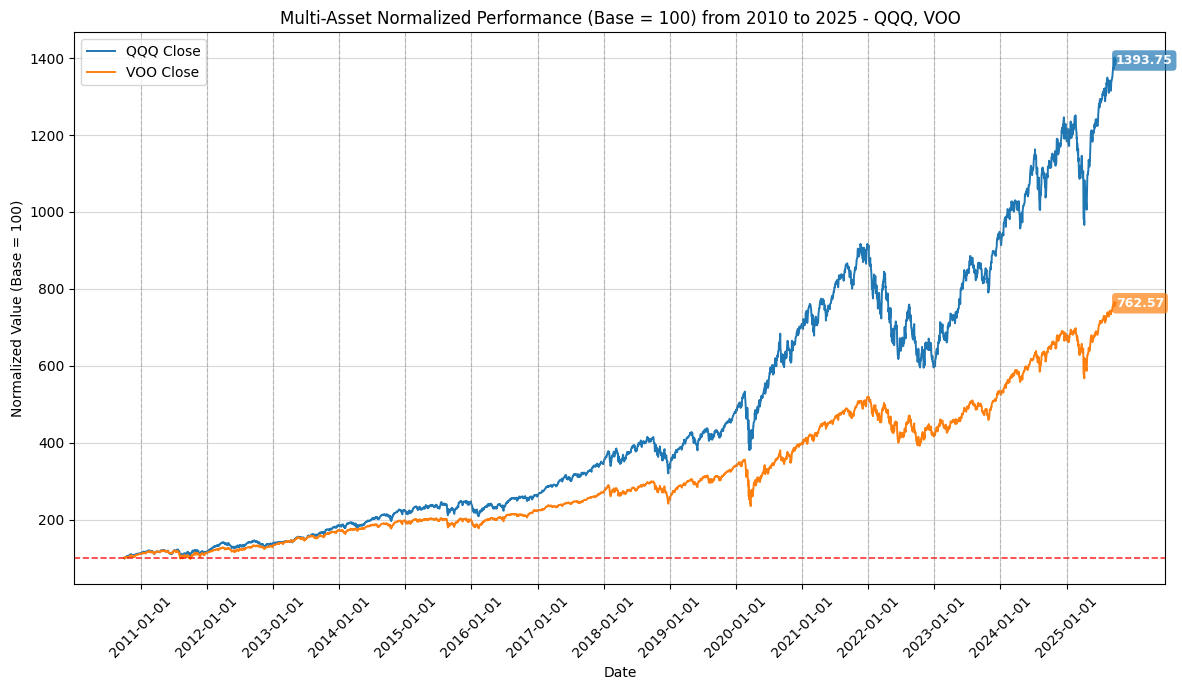


Performance Metrics
                        QQQ      VOO
Cumulative Return  1293.75%  662.57%
Annualized Return    19.26%   14.54%
Volatility (Ann.)    20.68%   17.21%
Max Drawdown        -35.12%  -33.99%
Sharpe Ratio (3%)      0.79     0.67

Top 5 Drawdowns (Peak to Trough)

QQQ:
------------------------------------------------------------
  #1: -35.12%
      Peak: 2021-12-27 → Trough: 2022-11-03 (310 days)
  #2: -28.56%
      Peak: 2020-02-19 → Trough: 2020-03-16 (25 days)
  #3: -22.80%
      Peak: 2018-08-29 → Trough: 2018-12-24 (117 days)
  #4: -22.77%
      Peak: 2025-02-19 → Trough: 2025-04-08 (47 days)
  #5: -16.10%
      Peak: 2015-12-01 → Trough: 2016-02-09 (70 days)

VOO:
------------------------------------------------------------
  #1: -33.99%
      Peak: 2020-02-19 → Trough: 2020-03-23 (32 days)
  #2: -24.52%
      Peak: 2022-01-03 → Trough: 2022-10-12 (281 days)
  #3: -19.48%
      Peak: 2018-09-20 → Trough: 2018-12-24 (95 days)
  #4: -18.75%
      Peak: 2011-04-29 → Tro

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

START_DATE = "2010-10-01"
END_DATE = "2025-09-30"

def calculate_metrics(df):
    returns = df["Close"].pct_change().dropna()

    yearly_returns = df["Close"].resample('YE').last().pct_change().dropna()

    cumulative_return = (df["Close"].iloc[-1] / df["Close"].iloc[0]) - 1

    # Annualized return (CAGR) using Geometric Mean of Daily Returns
    # 1. Add 1 to daily returns (1 + r1, 1 + r2, ...)
    # 2. Take the product (cumulative product)
    # 3. Raise to the power of (252 / number of trading days) and Substract 1

    # use 252 trading days per year for annualization
    num_trading_days = len(returns)

    if num_trading_days == 0:
        annualized_return = np.nan
    else:
        cumulative_growth = returns.add(1).prod()
        annualized_return = cumulative_growth ** (252 / num_trading_days) - 1

    volatility = returns.std() * np.sqrt(252)

    # calculate drawdowns with peak tracking
    prices = df["Close"]
    cumulative = prices / prices.iloc[0]
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    drawdown_events = []
    in_drawdown = False
    peak_date = None

    for i in range(len(cumulative)):
        current_date = cumulative.index[i]
        current_value = cumulative.iloc[i]
        current_max = running_max.iloc[i]

        if current_value == current_max:
            if in_drawdown and peak_date is not None:
                trough_idx = drawdown.loc[peak_date:current_date].idxmin()
                trough_dd = drawdown.loc[trough_idx]
                drawdown_events.append({
                    'peak_date': peak_date,
                    'trough_date': trough_idx,
                    'drawdown': trough_dd
                })
            in_drawdown = False
            peak_date = current_date
        elif current_value < current_max:
            in_drawdown = True

    if in_drawdown and peak_date is not None:
        trough_idx = drawdown.loc[peak_date:].idxmin()
        trough_dd = drawdown.loc[trough_idx]
        drawdown_events.append({
            'peak_date': peak_date,
            'trough_date': trough_idx,
            'drawdown': trough_dd
        })

    drawdown_events.sort(key=lambda x: x['drawdown'])
    top_drawdowns = []
    for event in drawdown_events:
        if len(top_drawdowns) >= 5:
            break
        is_distinct = True
        for selected in top_drawdowns:
            days_apart = abs((event['trough_date'] - selected['trough_date']).days)
            if days_apart < 252:
                is_distinct = False
                break
        if is_distinct:
            top_drawdowns.append(event)

    # Sharpe ratio (with 3% risk-free rate)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility != 0 else np.nan

    return {
        'yearly_returns': yearly_returns,
        'cumulative_return': cumulative_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'top_drawdowns': top_drawdowns
    }

def run_asset_analysis(tickers, start_date=START_DATE, end_date=END_DATE):
    data = {}
    for ticker in tickers:
        try:
            df = yf.Ticker(ticker).history(start=start_date, end=end_date)
            if df.empty:
                print(f"Warning: No data found for {ticker}")
                continue

            df["EMA200"] = df["Close"].ewm(span=200, adjust=False).mean()
            base_price = df["Close"].iloc[0]
            df["Norm_Close"] = (df["Close"] / base_price) * 100
            df["Norm_EMA200"] = (df["EMA200"] / base_price) * 100
            data[ticker] = df
        except Exception as e:
             print(f"Error processing ticker {ticker}: {e}")

    if not data:
        print("No valid data to analyze.")
        return

    metrics = {ticker: calculate_metrics(df) for ticker, df in data.items()}

    plt.figure(figsize=(12, 7))
    plt.style.use("seaborn-v0_8-pastel")
    plt.title(f"Multi-Asset Normalized Performance (Base = 100) from {start_date[:4]} to {end_date[:4]} - {', '.join(tickers)}")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value (Base = 100)")
    plt.grid(True, alpha=0.5)

    colors = plt.cm.tab10(range(len(data)))
    for idx, (ticker, df) in enumerate(data.items()):
        line, = plt.plot(df["Norm_Close"], linewidth=1.4, label=f"{ticker} Close", color=colors[idx])

        final_value = df["Norm_Close"].iloc[-1]
        final_date = df.index[-1]
        plt.text(final_date, final_value, f'{final_value:.2f}',
                 fontsize=9, va='center', ha='left',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[idx], alpha=0.7, edgecolor='none'),
                 color='white', fontweight='bold')

    plt.axhline(y=100, color='red', linestyle='--', linewidth=1.2, alpha=0.8)

    sample_df = next(iter(data.values()))
    years = pd.date_range(start=start_date, end=end_date, freq="YS", tz=sample_df.index.tz)
    for year in years:
        plt.axvline(x=year, color='grey', alpha=0.4, linestyle='--', linewidth=0.8)
    plt.xticks(years, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

    all_years = sorted(list(set(y for ticker in metrics for y in metrics[ticker]['yearly_returns'].index.year)))
    yearly_df = pd.DataFrame(index=all_years)
    for ticker in metrics:
        yr = metrics[ticker]['yearly_returns']
        yearly_df[ticker] = yr.groupby(yr.index.year).first()
    yearly_df = yearly_df * 100
    #print(yearly_df.to_string(float_format=lambda x: f'{x:>8.2f}%'))

    print("\n" + "="*30)
    print("Performance Metrics")
    print("="*30)
    metrics_df = pd.DataFrame({
        ticker: {
            'Cumulative Return': f"{m['cumulative_return']*100:.2f}%",
            'Annualized Return': f"{m['annualized_return']*100:.2f}%",
            'Volatility (Ann.)': f"{m['volatility']*100:.2f}%",
            'Max Drawdown': f"{m['max_drawdown']*100:.2f}%",
            'Sharpe Ratio (3%)': f"{m['sharpe_ratio']:.2f}"
        }
        for ticker, m in metrics.items()
    })
    print(metrics_df.to_string())

    print("\n" + "="*30)
    print("Top 5 Drawdowns (Peak to Trough)")
    print("="*30)
    for ticker in metrics:
        print(f"\n{ticker}:")
        print("-" * 60)
        for i, dd in enumerate(metrics[ticker]['top_drawdowns'], 1):
            peak_str = dd['peak_date'].strftime('%Y-%m-%d')
            trough_str = dd['trough_date'].strftime('%Y-%m-%d')
            duration = (dd['trough_date'] - dd['peak_date']).days
            print(f"  #{i}: {dd['drawdown']*100:.2f}%")
            print(f"      Peak: {peak_str} → Trough: {trough_str} ({duration} days)")

    print("\n" + "="*30)

tickers_0 = ["QQQ", "VOO"]
run_asset_analysis(tickers_0)

**Interpretation:**
- Script 1 and Script 2's result is exactly the same (annualized return, volatility, Max DD, Sharpe Ratio), only Cumulative Return have slightly larger differ.
- It is believed that this is due to they are computed via different method: Script 1 takes a product of annual returns, while Script 2 uses a direct ratio of prices from the first date to the last date.
- This script (Script 2) shows the Top 5 drawdown periods, all of which are significant events:
- **2015:** Concerns about a slowdown in global growth and turmoil in the oil market.
- **2018:** Global trade tensions (specifically US-China trade war concerns).
- **2020:** The rapid onset of the COVID-19 pandemic.
- **2022:** Soaring inflation (up to >8%) and aggressive monetary policy tightening (hike rates) by the Fed.
- **2025:** The retaliatory tariffs promulgated by President Trump announced on April 2.

## **15Y Progressive DCA vs Opportunistic vs Perfect Timing (Threshold = 15%)**
Starting from USD 500 every month, increase USD 250 per month every 2 years.

Eg. From 3rd year, invest USD 750 every month; from 5th year, invest USD1000 every month.

**STRATEGY OVERVIEW**
- **Perfect-timing:** Save everything in money market fund, then magically buy at the absolute lowest point of each market crash (≥15%).

- **Opportunistic:** When market is doing well → Save your money in a safe money market fund (earning 3% interest); When market crashes ≥15% → Deploy all saved money in MMF AND invest all future contributions directly into stocks until market recovers to <5% from the previous peak. Its basically keep your cash ready and earning minor interest while waiting for market promotion. Also, buy more when prices are low.

- **Dollar Cost Averaging (DCA)**: Every month, you automatically buy stocks with your $500, no matter what the market is doing. Simple, consistent, and removes emotion from investing. As long as the asset is uptrend, buy at both good and bad prices to average cost.

In [ ]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from tabulate import tabulate
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')

SHOW_DETAILED_LOGS = True
SHOW_DRAWDOWN_PERIODS = True
SHOW_TRANSACTION_SUMMARY = False

TICKERS = ['QQQ']

base_investment_amount = 500
investment_increase = 250
increase_interval = 2
mmf_annual_rate = 0.03
drawdown_threshold = 0.15
recovery_threshold = 0.05

start_date = "2010-10-01"
end_date = "2025-10-01"

INITIAL_DEPOSIT = 0

print(f"Starting Investment: ${base_investment_amount:,} / month")
print(f"Investment Increase: ${investment_increase:,} / {increase_interval} years")
print(f"MMF Annual Rate: {mmf_annual_rate*100:.1f}%")
print(f"Drawdown Threshold: {drawdown_threshold*100:.0f}%")
print(f"Recovery Threshold: {recovery_threshold*100:.0f}%")
print(f"Initial Deposit: ${INITIAL_DEPOSIT:,.2f}")
print(f"Period: {start_date} to {end_date}")
print()

data = yf.download(TICKERS, start=start_date, end=end_date, progress=False)[['Open', 'Close']]
data = data.sort_index()

def find_nearest_trading_day(target_date, data_index, direction="nearest"):
    target_date = pd.to_datetime(target_date)
    if direction == "before":
        available = data_index[data_index <= target_date]
        return available[-1] if len(available) > 0 else data_index[0]
    elif direction == "after":
        available = data_index[data_index >= target_date]
        return available[0] if len(available) > 0 else data_index[-1]
    else:
        differences = abs(data_index - target_date)
        return data_index[differences.argmin()]

def calculate_mmf_growth(principal, annual_rate, days):
    daily_rate = annual_rate / 365
    return principal * ((1 + daily_rate) ** days)

def generate_investment_schedule(start_date, end_date, base_amount, increase_amount, increase_interval):
    schedule = []
    end_dt = pd.to_datetime(end_date)
    start_dt = pd.to_datetime(start_date)

    # First investment is one month after start_date (salary-based logic)
    current_date = start_dt + relativedelta(months=1)

    while current_date <= end_dt:
        years_elapsed = (current_date.year - start_dt.year) + (current_date.month - start_dt.month) / 12
        increases_applied = int(years_elapsed // increase_interval)
        current_amount = base_amount + (increases_applied * increase_amount)

        schedule.append({
            'date': current_date,
            'amount': current_amount,
            'years_elapsed': years_elapsed
        })

        current_date += relativedelta(months=1)

    return schedule

investment_schedule = generate_investment_schedule(start_date, end_date, base_investment_amount, investment_increase, increase_interval)

def identify_drawdown_periods(ticker_close, all_dates):
    peak_data = {}
    running_peak = 0.0

    for date in all_dates:
        current_price = ticker_close.loc[date]
        running_peak = max(running_peak, current_price)
        peak_data[date] = running_peak

    drawdown_periods = []
    in_drawdown = False
    drawdown_start = None
    drawdown_peak = 0.0

    for i, date in enumerate(all_dates):
        current_close = ticker_close.loc[date]
        historical_peak = peak_data[date]
        current_drawdown = (historical_peak - current_close) / historical_peak if historical_peak > 0 else 0

        if not in_drawdown and current_drawdown >= drawdown_threshold:
            in_drawdown = True
            drawdown_start = date
            drawdown_peak = historical_peak
        elif in_drawdown and current_drawdown < recovery_threshold:
            drawdown_dates = all_dates[(all_dates >= drawdown_start) & (all_dates <= date)]
            drawdown_prices = ticker_close.loc[drawdown_dates]
            lowest_date = drawdown_prices.idxmin()
            lowest_price = drawdown_prices.min()
            max_drawdown = (drawdown_peak - lowest_price) / drawdown_peak

            drawdown_periods.append({
                'start_date': drawdown_start,
                'end_date': date,
                'peak_price': drawdown_peak,
                'lowest_date': lowest_date,
                'lowest_price': lowest_price,
                'max_drawdown': max_drawdown
            })
            in_drawdown = False

    if in_drawdown:
        end_date_parsed = pd.to_datetime(end_date)
        final_trading_date = find_nearest_trading_day(end_date_parsed, all_dates, "before")
        drawdown_dates = all_dates[(all_dates >= drawdown_start) & (all_dates <= final_trading_date)]
        drawdown_prices = ticker_close.loc[drawdown_dates]
        lowest_date = drawdown_prices.idxmin()
        lowest_price = drawdown_prices.min()
        max_drawdown = (drawdown_peak - lowest_price) / drawdown_peak

        drawdown_periods.append({
            'start_date': drawdown_start,
            'end_date': final_trading_date,
            'peak_price': drawdown_peak,
            'lowest_date': lowest_date,
            'lowest_price': lowest_price,
            'max_drawdown': max_drawdown
        })

    return drawdown_periods, peak_data

def run_perfect_timing_strategy(ticker):
    ticker_open = data['Open'][ticker].dropna()
    ticker_close = data['Close'][ticker].dropna()
    all_dates = ticker_open.index

    mmf_balance = 0.0
    total_etf_shares = 0.0
    total_invested_in_etf = 0.0
    total_saved_to_mmf = 0.0

    transactions = []
    mmf_transactions = []
    detailed_log = []

    drawdown_periods, peak_data = identify_drawdown_periods(ticker_close, all_dates)

    investment_dates = {}
    for inv in investment_schedule:
        trading_date = find_nearest_trading_day(inv['date'], all_dates, "after")
        investment_dates[trading_date] = inv['amount']

    if INITIAL_DEPOSIT > 0:
        init_date = find_nearest_trading_day(start_date, all_dates, "after")
        is_perfect_buy = init_date in [dp['lowest_date'] for dp in drawdown_periods]

        if is_perfect_buy:
            init_price = ticker_open.loc[init_date]
            shares = INITIAL_DEPOSIT / init_price
            total_etf_shares += shares
            total_invested_in_etf += INITIAL_DEPOSIT

            transactions.append({
                'Date': init_date,
                'Type': 'Initial Deposit Purchase',
                'Amount': INITIAL_DEPOSIT,
                'Shares': shares,
                'Price': init_price,
                'Drawdown': 0,
                'Peak': ticker_close.loc[init_date],
                'Close_Price': ticker_close.loc[init_date]
            })

            detailed_log.append({
                'Date': init_date.strftime('%Y-%m-%d'),
                'Investment': f"${INITIAL_DEPOSIT:,.2f}",
                'Buy Price': f"${init_price:.2f}",
                'Shares Bought': f"{shares:.4f}",
                'Total Shares': f"{total_etf_shares:.4f}",
                'Total Invested': f"${INITIAL_DEPOSIT:,.2f}"
            })
        else:
            mmf_balance += INITIAL_DEPOSIT
            mmf_transactions.append({'Date': init_date, 'Amount': INITIAL_DEPOSIT, 'Balance': mmf_balance})
            total_saved_to_mmf += INITIAL_DEPOSIT

    perfect_buy_dates = [dp['lowest_date'] for dp in drawdown_periods]

    for i, date in enumerate(all_dates):
        current_open = ticker_open.loc[date]
        current_close = ticker_close.loc[date]

        if date in investment_dates:
            if mmf_transactions:
                last_tx_date = mmf_transactions[-1]['Date']
                days_elapsed = (date - last_tx_date).days
                if days_elapsed > 0 and mmf_balance > 0:
                    mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_elapsed)
            elif INITIAL_DEPOSIT > 0 and mmf_balance > 0:
                init_date = find_nearest_trading_day(start_date, all_dates, "after")
                days_elapsed = (date - init_date).days
                if days_elapsed > 0 and mmf_balance > 0:
                    mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_elapsed)

            investment_amount = investment_dates[date]
            mmf_balance += investment_amount
            total_saved_to_mmf += investment_amount
            mmf_transactions.append({
                'Date': date,
                'Amount': investment_amount,
                'Balance': mmf_balance
            })

        if date in perfect_buy_dates and mmf_balance > 0:
            if mmf_transactions:
                last_mmf_date = mmf_transactions[-1]['Date']
                days_elapsed = (date - last_mmf_date).days
                if days_elapsed > 0:
                    mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_elapsed)

            drawdown_info = next(dp for dp in drawdown_periods if dp['lowest_date'] == date)
            lump_sum_amount = mmf_balance
            shares_purchased = lump_sum_amount / current_open
            total_etf_shares += shares_purchased
            total_invested_in_etf += lump_sum_amount

            transactions.append({
                'Date': date,
                'Type': 'Perfect Timing Purchase',
                'Amount': lump_sum_amount,
                'Shares': shares_purchased,
                'Price': current_open,
                'Drawdown': drawdown_info['max_drawdown'],
                'Peak': drawdown_info['peak_price'],
                'Close_Price': current_close
            })

            detailed_log.append({
                'Date': date.strftime('%Y-%m-%d'),
                'Investment': f"${lump_sum_amount:,.2f}",
                'Buy Price': f"${current_open:.2f}",
                'Shares Bought': f"{shares_purchased:.4f}",
                'Total Shares': f"{total_etf_shares:.4f}",
                'Total Invested': f"${total_invested_in_etf:,.2f}"
            })

            mmf_balance = 0.0

    final_date = find_nearest_trading_day(end_date, all_dates, "before")
    final_price = ticker_close.loc[final_date]

    if mmf_balance > 0:
        if mmf_transactions:
            last_tx_date = mmf_transactions[-1]['Date']
        else:
            last_tx_date = find_nearest_trading_day(start_date, all_dates, "after")

        days_to_end = (pd.to_datetime(end_date) - last_tx_date).days
        if days_to_end > 0:
            mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_to_end)

    final_etf_value = total_etf_shares * final_price
    final_portfolio_value = final_etf_value + mmf_balance
    total_returns = final_portfolio_value - total_saved_to_mmf
    roi_percentage = (total_returns / total_saved_to_mmf) * 100 if total_saved_to_mmf > 0 else 0
    avg_price = total_invested_in_etf / total_etf_shares if total_etf_shares > 0 else 0

    return {
        'transactions': transactions,
        'drawdown_periods': drawdown_periods,
        'detailed_log': pd.DataFrame(detailed_log),
        'summary': {
            'Total Invested (MMF)': f"${total_saved_to_mmf:,.2f}",
            'Total Invested (ETF)': f"${total_invested_in_etf:,.2f}",
            'MMF Balance': f"${mmf_balance:,.2f}",
            'Shares Acquired': f"{total_etf_shares:.4f}",
            'Avg Price': f"${avg_price:.2f}",
            'Final Price': f"${final_price:.2f}",
            'Final ETF Value': f"${final_etf_value:,.2f}",
            'Portfolio Value': f"${final_portfolio_value:,.2f}",
            'Total Returns': f"${total_returns:,.2f}",
            'ROI (%)': f"{roi_percentage:.2f}%",
            'Perfect_Count': len([tx for tx in transactions if 'Purchase' in tx.get('Type', '')]),
            'Opportunistic_Count': ''
        }
    }

def run_mmf_opportunistic_strategy(ticker):
    ticker_open = data['Open'][ticker].dropna()
    ticker_close = data['Close'][ticker].dropna()
    all_dates = ticker_open.index

    mmf_balance = 0.0
    total_etf_shares = 0.0
    total_invested_in_etf = 0.0
    total_saved_to_mmf = 0.0

    transactions = []
    mmf_transactions = []
    detailed_log = []

    drawdown_periods, peak_data = identify_drawdown_periods(ticker_close, all_dates)

    investment_dates = {}
    for inv in investment_schedule:
        trading_date = find_nearest_trading_day(inv['date'], all_dates, "after")
        investment_dates[trading_date] = inv['amount']

    if INITIAL_DEPOSIT > 0:
        init_date = find_nearest_trading_day(start_date, all_dates, "after")
        historical_peak = peak_data[init_date]
        current_close = ticker_close.loc[init_date]
        current_drawdown = (historical_peak - current_close) / historical_peak if historical_peak > 0 else 0

        if current_drawdown >= drawdown_threshold:
            init_price = ticker_open.loc[init_date]
            shares = INITIAL_DEPOSIT / init_price
            total_etf_shares += shares
            total_invested_in_etf += INITIAL_DEPOSIT

            transactions.append({
                'Date': init_date,
                'Type': 'Initial Deposit Purchase (In Drawdown)',
                'Amount': INITIAL_DEPOSIT,
                'Shares': shares,
                'Price': init_price,
                'Drawdown': current_drawdown
            })

            detailed_log.append({
                'Date': init_date.strftime('%Y-%m-%d'),
                'Investment': f"${INITIAL_DEPOSIT:,.2f}",
                'Buy Price': f"${init_price:.2f}",
                'Shares Bought': f"{shares:.4f}",
                'Total Shares': f"{total_etf_shares:.4f}",
                'Total Invested': f"${INITIAL_DEPOSIT:,.2f}"
            })
        else:
            mmf_balance += INITIAL_DEPOSIT
            mmf_transactions.append({'Date': init_date, 'Amount': INITIAL_DEPOSIT, 'Balance': mmf_balance})
            total_saved_to_mmf += INITIAL_DEPOSIT

    in_drawdown = False
    has_deployed_mmf = False

    for i, date in enumerate(all_dates):
        current_open = ticker_open.loc[date]
        current_close = ticker_close.loc[date]
        historical_peak = peak_data[date]
        current_drawdown = (historical_peak - current_close) / historical_peak if historical_peak > 0 else 0

        is_investment_date = date in investment_dates

        if not in_drawdown and current_drawdown >= drawdown_threshold:
            in_drawdown = True
            has_deployed_mmf = False
        elif in_drawdown and current_drawdown < recovery_threshold:
            in_drawdown = False
            has_deployed_mmf = False

        if is_investment_date:
            if mmf_transactions:
                last_tx_date = mmf_transactions[-1]['Date']
                days_elapsed = (date - last_tx_date).days
                if days_elapsed > 0 and mmf_balance > 0:
                    new_mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_elapsed)
                    mmf_balance = new_mmf_balance
            elif INITIAL_DEPOSIT > 0 and mmf_balance > 0:
                init_date = find_nearest_trading_day(start_date, all_dates, "after")
                days_elapsed = (date - init_date).days
                if days_elapsed > 0 and mmf_balance > 0:
                    mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_elapsed)

            investment_amount = investment_dates[date]
            total_saved_to_mmf += investment_amount

            if in_drawdown:
                shares_purchased = investment_amount / current_open
                total_etf_shares += shares_purchased
                total_invested_in_etf += investment_amount

                transactions.append({
                    'Date': date,
                    'Type': 'Regular Investment (In Drawdown)',
                    'Amount': investment_amount,
                    'Shares': shares_purchased,
                    'Price': current_open,
                    'Drawdown': current_drawdown
                })

                detailed_log.append({
                    'Date': date.strftime('%Y-%m-%d'),
                    'Investment': f"${investment_amount:,.2f}",
                    'Buy Price': f"${current_open:.2f}",
                    'Shares Bought': f"{shares_purchased:.2f}",
                    'Total Shares': f"{total_etf_shares:.2f}",
                    'Total Invested': f"${total_invested_in_etf:,.2f}"
                })
            else:
                mmf_balance += investment_amount
                mmf_transactions.append({'Date': date, 'Amount': investment_amount, 'Balance': mmf_balance})

        if in_drawdown and not has_deployed_mmf and mmf_balance > 0:
            if mmf_transactions:
                last_mmf_date = mmf_transactions[-1]['Date']
                days_elapsed = (date - last_mmf_date).days
                if days_elapsed > 0:
                    mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_elapsed)

            lump_sum_amount = mmf_balance
            shares_purchased = lump_sum_amount / current_open
            total_etf_shares += shares_purchased
            total_invested_in_etf += lump_sum_amount

            transactions.append({
                'Date': date,
                'Type': 'MMF Deployment',
                'Amount': lump_sum_amount,
                'Shares': shares_purchased,
                'Price': current_open,
                'Drawdown': current_drawdown
            })

            detailed_log.append({
                'Date': date.strftime('%Y-%m-%d'),
                'Investment': f"${lump_sum_amount:,.2f}",
                'Buy Price': f"${current_open:.2f}",
                'Shares Bought': f"{shares_purchased:.2f}",
                'Total Shares': f"{total_etf_shares:.2f}",
                'Total Invested': f"${total_invested_in_etf:,.2f}"
            })

            mmf_balance = 0.0
            has_deployed_mmf = True

    final_date = find_nearest_trading_day(end_date, all_dates, "before")
    final_price = ticker_close.loc[final_date]

    if mmf_balance > 0:
        last_tx_date = final_date
        if mmf_transactions:
            last_tx_date = mmf_transactions[-1]['Date']
        elif INITIAL_DEPOSIT > 0 and total_saved_to_mmf == INITIAL_DEPOSIT:
            last_tx_date = find_nearest_trading_day(start_date, all_dates, "after")

        days_to_end = (pd.to_datetime(end_date) - last_tx_date).days
        if days_to_end > 0:
            mmf_balance = calculate_mmf_growth(mmf_balance, mmf_annual_rate, days_to_end)

    final_etf_value = total_etf_shares * final_price
    final_portfolio_value = final_etf_value + mmf_balance
    total_returns = final_portfolio_value - total_saved_to_mmf
    roi_percentage = (total_returns / total_saved_to_mmf) * 100 if total_saved_to_mmf > 0 else 0
    avg_price = total_invested_in_etf / total_etf_shares if total_etf_shares > 0 else 0

    return {
        'transactions': transactions,
        'detailed_log': pd.DataFrame(detailed_log),
        'summary': {
            'Total Invested (MMF)': f"${total_saved_to_mmf:,.2f}",
            'Total Invested (ETF)': f"${total_invested_in_etf:,.2f}",
            'MMF Balance': f"${mmf_balance:,.2f}",
            'Shares Acquired': f"{total_etf_shares:.4f}",
            'Avg Price': f"${avg_price:.2f}",
            'Final Price': f"${final_price:.2f}",
            'Final ETF Value': f"${final_etf_value:,.2f}",
            'Portfolio Value': f"${final_portfolio_value:,.2f}",
            'Total Returns': f"${total_returns:,.2f}",
            'ROI (%)': f"{roi_percentage:.2f}%",
            'Perfect_Count': '',
            'Opportunistic_Count': len(transactions)
        }
    }

def run_original_dca_strategy(ticker):
    ticker_open = data['Open'][ticker].dropna()
    ticker_close = data['Close'][ticker].dropna()
    all_dates = ticker_open.index

    total_shares = 0.0
    total_invested = 0.0
    detailed_log = []

    if INITIAL_DEPOSIT > 0:
        init_date = find_nearest_trading_day(start_date, all_dates, "after")
        init_price = ticker_open.loc[init_date]
        shares = INITIAL_DEPOSIT / init_price
        total_shares += shares
        total_invested += INITIAL_DEPOSIT

        detailed_log.append({
            'Date': init_date.strftime('%Y-%m-%d'),
            'Investment': f"${INITIAL_DEPOSIT:,.2f}",
            'Buy Price': f"${init_price:.2f}",
            'Shares Bought': f"{shares:.2f}",
            'Total Shares': f"{total_shares:.2f}",
            'Total Invested': f"${total_invested:,.2f}"
        })

    for investment in investment_schedule:
        inv_date = investment['date']
        investment_amount = investment['amount']

        trading_date = find_nearest_trading_day(inv_date, all_dates, "after")
        buy_price = ticker_open.loc[trading_date]
        shares = investment_amount / buy_price

        total_shares += shares
        total_invested += investment_amount

        detailed_log.append({
            'Date': trading_date.strftime('%Y-%m-%d'),
            'Investment': f"${investment_amount:,.2f}",
            'Buy Price': f"${buy_price:.2f}",
            'Shares Bought': f"{shares:.2f}",
            'Total Shares': f"{total_shares:.2f}",
            'Total Invested': f"${total_invested:,.2f}"
        })

    final_date = find_nearest_trading_day(end_date, all_dates, "before")
    final_price = ticker_close.loc[final_date]
    final_value = total_shares * final_price
    total_returns = final_value - total_invested
    roi_percentage = (total_returns / total_invested) * 100 if total_invested > 0 else 0
    avg_price = total_invested / total_shares if total_shares > 0 else 0

    return {
        'detailed_log': pd.DataFrame(detailed_log),
        'Total Invested (MMF)': '',
        'Total Invested (ETF)': f"${total_invested:,.2f}",
        'MMF Balance': '',
        'Shares Acquired': f"{total_shares:.2f}",
        'Avg Price': f"${avg_price:.2f}",
        'Final Price': f"${final_price:.2f}",
        'Final ETF Value': f"${final_value:,.2f}",
        'Portfolio Value': f"${final_value:,.2f}",
        'Total Returns': f"${total_returns:,.2f}",
        'ROI (%)': f"{roi_percentage:.2f}%",
        'Perfect_Count': '',
        'Opportunistic_Count': ''
    }

perfect_timing_results = {}
opportunistic_results = {}
dca_results = {}

for ticker in TICKERS:
    perfect_timing_results[ticker] = run_perfect_timing_strategy(ticker)
    opportunistic_results[ticker] = run_mmf_opportunistic_strategy(ticker)
    dca_results[ticker] = run_original_dca_strategy(ticker)

print("\n" + "="*60)
print("STRATEGY COMPARISON")
print("="*60)

for ticker in TICKERS:
    if SHOW_DRAWDOWN_PERIODS:
        print(f"\n{ticker} - DRAWDOWN PERIODS IDENTIFIED:")
        print("-" * 60)
        for i, dp in enumerate(perfect_timing_results[ticker]['drawdown_periods'], 1):
            print(f"  {i}. {dp['start_date'].strftime('%Y-%m-%d')} to {dp['end_date'].strftime('%Y-%m-%d')}")
            print(f"    Peak: ${dp['peak_price']:.2f} \u2192 Lowest: ${dp['lowest_price']:.2f} "
                  f"({dp['max_drawdown']*100:.1f}% down) on {dp['lowest_date'].strftime('%Y-%m-%d')}\n")

    if SHOW_TRANSACTION_SUMMARY:
        print(f"\n{ticker} - PERFECT TIMING TRANSACTIONS:")
        print("-" * 60)
        for tx in perfect_timing_results[ticker]['transactions']:
            tx_type = tx.get('Type', '')
            if 'Initial Deposit Purchase' in tx_type:
                print(f"  {tx['Date'].strftime('%Y-%m-%d')} (INITIAL): ${tx['Amount']:,.0f} \u2192 {tx['Shares']:.2f} shares at ${tx['Price']:.2f}")
            elif 'Perfect Timing Purchase' in tx_type:
                print(f"  {tx['Date'].strftime('%Y-%m-%d')}: ${tx['Amount']:,.0f} \u2192 {tx['Shares']:.2f} shares at ${tx['Price']:.2f}")

        print(f"\n{ticker} - OPPORTUNISTIC TRANSACTIONS:")
        print("-" * 60)
        for tx in opportunistic_results[ticker]['transactions']:
            tx_type = tx.get('Type', '')
            if 'Initial Deposit Purchase' in tx_type:
                print(f"  {tx['Date'].strftime('%Y-%m-%d')} (INITIAL): ${tx['Amount']:,.0f} \u2192 {tx['Shares']:.2f} shares at ${tx['Price']:.2f}")
            else:
                print(f"  {tx['Date'].strftime('%Y-%m-%d')}: ${tx['Amount']:,.0f} \u2192 {tx['Shares']:.2f} shares at ${tx['Price']:.2f}")

if SHOW_DETAILED_LOGS:
    print("\n" + "="*60)
    print("DETAILED TRANSACTION LOGS")
    print("="*60)

    for ticker in TICKERS:
        print(f"\n{ticker} - PERFECT TIMING:")
        print("-" * 60)
        df = perfect_timing_results[ticker]['detailed_log']
        if not df.empty:
            print(tabulate(df, headers='keys', tablefmt='pipe', stralign='center', showindex=False))
        else:
            print("No transactions recorded.")

        print(f"\n{ticker} - OPPORTUNISTIC:")
        print("-" * 60)
        df = opportunistic_results[ticker]['detailed_log']
        if not df.empty:
            print(tabulate(df, headers='keys', tablefmt='pipe', stralign='center', showindex=False))
        else:
            print("No transactions recorded.")

        print(f"\n{ticker} - DCA:")
        print("-" * 60)
        df = dca_results[ticker]['detailed_log']
        if not df.empty:
            print(tabulate(df, headers='keys', tablefmt='pipe', stralign='center', showindex=False))
        else:
            print("No transactions recorded.")

print(f"\n\n{'='*60}")
print("STRATEGY COMPARISON TABLE")
print(f"{'='*60}")

column_order = [
    'Total Invested (MMF)',
    'Total Invested (ETF)',
    'MMF Balance',
    'Shares Acquired',
    'Avg Price',
    'Final Price',
    'Final ETF Value',
    'Portfolio Value',
    'Total Returns',
    'ROI (%)',
    'Perfect_Count',
    'Opportunistic_Count'
]

comparison_data = {}
for ticker in TICKERS:
    perfect_results = perfect_timing_results[ticker]['summary']
    opp_results = opportunistic_results[ticker]['summary']
    dca_results_ticker = dca_results[ticker]

    comparison_data[f'{ticker}_Perfect'] = perfect_results
    comparison_data[f'{ticker}_Opportunistic'] = opp_results
    comparison_data[f'{ticker}_DCA'] = dca_results_ticker

comparison_df = pd.DataFrame(comparison_data).T
comparison_df = comparison_df.reindex(columns=column_order)

print(tabulate(
    comparison_df,
    headers='keys',
    tablefmt='pipe',
    stralign='center',
    numalign='center'
))

print(f"\n\n{'='*60}")
print(f"PERFORMANCE ANALYSIS")
print("="*60)

total_scheduled_savings = sum([inv['amount'] for inv in investment_schedule]) + INITIAL_DEPOSIT

for ticker in TICKERS:
    perfect_final = float(perfect_timing_results[ticker]['summary']['Portfolio Value'].replace('$', '').replace(',', ''))
    perfect_roi = float(perfect_timing_results[ticker]['summary']['ROI (%)'].replace('%', ''))

    opp_final = float(opportunistic_results[ticker]['summary']['Portfolio Value'].replace('$', '').replace(',', ''))
    opp_roi = float(opportunistic_results[ticker]['summary']['ROI (%)'].replace('%', ''))

    dca_final = float(dca_results[ticker]['Portfolio Value'].replace('$', '').replace(',', ''))
    dca_roi = float(dca_results[ticker]['ROI (%)'].replace('%', ''))

    perfect_vs_opp = perfect_final - opp_final
    perfect_vs_dca = perfect_final - dca_final
    opp_vs_dca = opp_final - dca_final

    print(f"{ticker} PERFORMANCE COMPARISON:")
    print(f"Perfect Timing:")
    print(f"\t\u00B7 Final Value: ${perfect_final:,.2f}")
    print(f"\t\u00B7 ROI: {perfect_roi:.2f}%")

    perfect_count = perfect_timing_results[ticker]['summary']['Perfect_Count']
    print(f"\t\u00B7 Purchases: {perfect_count}")

    print(f"Opportunistic:")
    print(f"\t\u00B7 Final Value: ${opp_final:,.2f}")
    print(f"\t\u00B7 ROI: {opp_roi:.2f}%")
    print(f"\t\u00B7 Purchases: {opportunistic_results[ticker]['summary']['Opportunistic_Count']}")

    print(f"Regular DCA:")
    print(f"\t\u00B7 Final Value: ${dca_final:,.2f}")
    print(f"\t\u00B7 ROI: {dca_roi:.2f}%")

    print(f"\nPerformance Gaps:")

    perfect_vs_opp_percent = (perfect_vs_opp/opp_final)*100 if opp_final != 0 else float('inf')
    perfect_vs_dca_percent = (perfect_vs_dca/dca_final)*100 if dca_final != 0 else float('inf')
    opp_vs_dca_percent = (opp_vs_dca/dca_final)*100 if dca_final != 0 else float('inf')

    print(f"\t\u00B7 Perfect vs Opportunistic: ${perfect_vs_opp:,.2f} ({perfect_vs_opp_percent:.1f}% better)")
    print(f"\t\u00B7 Perfect vs DCA: ${perfect_vs_dca:,.2f} ({perfect_vs_dca_percent:.1f}% better)")
    print(f"\t\u00B7 Opportunistic vs DCA: ${opp_vs_dca:,.2f} ({opp_vs_dca_percent:.1f}% better)\n\n")

print(f"===== Summary =====")
print(f"Total Investment Contributed: ${total_scheduled_savings:,}")
print(f"Drawdown Threshold: {drawdown_threshold*100:.0f}%")
print(f"Recovery Threshold: {recovery_threshold*100:.0f}%")

Starting Investment: $500 / month
Investment Increase: $250 / 2 years
MMF Annual Rate: 3.0%
Drawdown Threshold: 15%
Recovery Threshold: 5%
Initial Deposit: $0.00
Period: 2010-10-01 to 2025-10-01


STRATEGY COMPARISON

QQQ - DRAWDOWN PERIODS IDENTIFIED:
------------------------------------------------------------
  1. 2011-08-08 to 2011-09-16
    Peak: $52.56 → Lowest: $44.10 (16.1% down) on 2011-08-19

  2. 2016-02-08 to 2016-03-29
    Peak: $106.92 → Lowest: $89.70 (16.1% down) on 2016-02-09

  3. 2018-12-17 to 2019-03-13
    Peak: $178.12 → Lowest: $137.51 (22.8% down) on 2018-12-24

  4. 2020-03-09 to 2020-05-08
    Peak: $228.96 → Lowest: $163.57 (28.6% down) on 2020-03-16

  5. 2022-01-27 to 2023-07-17
    Peak: $393.94 → Lowest: $255.59 (35.1% down) on 2022-11-03

  6. 2025-04-03 to 2025-05-13
    Peak: $537.49 → Lowest: $415.11 (22.8% down) on 2025-04-08


DETAILED TRANSACTION LOGS

QQQ - PERFECT TIMING:
------------------------------------------------------------
|    Date    |

**Analysis:**
- Surprisingly, in both QQQ and VOO, **Regular DCA strategy is the best strategy** even beating Perfect-timing!
- It is believed that the reason is because there's very less downturn >=15% before 2020, and more downturns after 2020 (relatively higher costs even after market crash) --> DCA able to buy the assets at very cheap prices in early years, which makes them have the lower average price and more shares acquired.
- Another reason is because even the Perfect-timing strategy buys at the lowest point of a downturn, **it doesn't sell at the highest point of a peak** and invest again in a lump sum on the next lowest point.
- Opportunistic strategy is more realistic version of Perfect-timing, but also losing simple DCA in any mean. Thus, a key point within the investment landscape is discipline, providing the selected asset is a long-bull/uptrend asset.


ROI here means the total return of the portfolio over total invested amount, not the return of the asset.

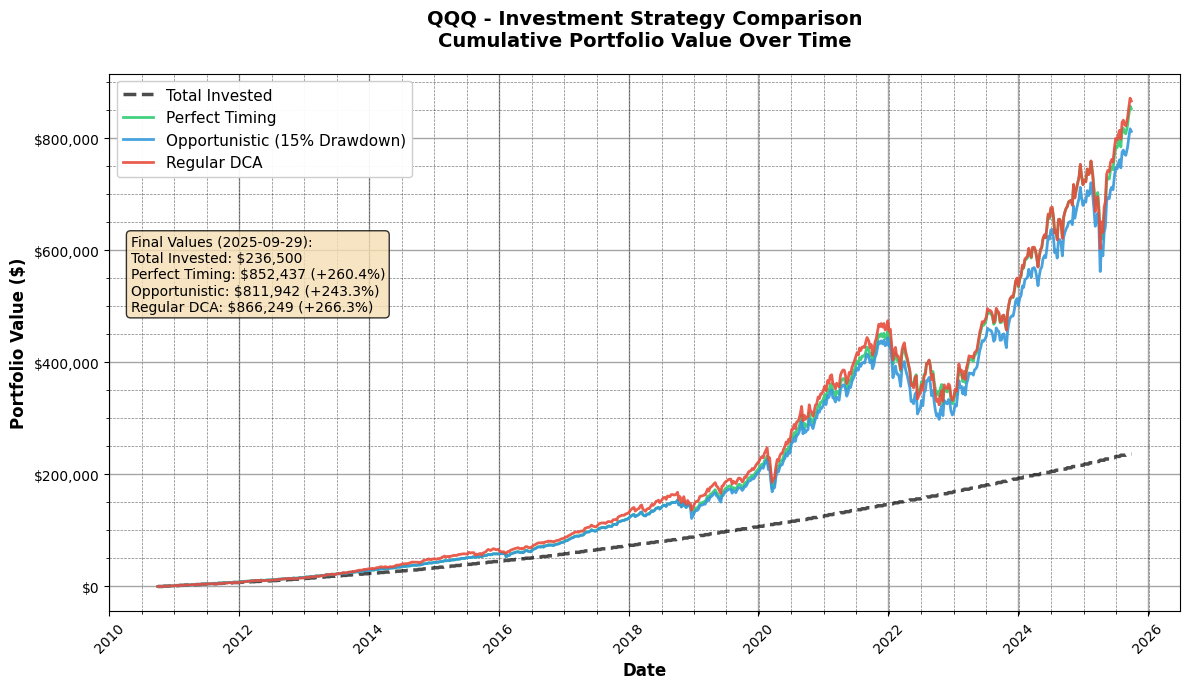

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import AutoMinorLocator

def plot_strategy_comparison(ticker, perfect_timing_results, opportunistic_results,
                             dca_results, investment_schedule, data, start_date, end_date):

    ticker_close = data['Close'][ticker].dropna()
    all_dates = ticker_close.index

    dates = []
    cumulative_invested = []
    perfect_values = []
    opp_values = []
    dca_values = []

    total_invested_so_far = 0

    perfect_mmf = 0
    perfect_shares = 0
    perfect_invested_etf = 0
    perfect_tx_idx = 0
    perfect_transactions = perfect_timing_results['transactions']

    opp_mmf = 0
    opp_shares = 0
    opp_tx_idx = 0
    opp_transactions = opportunistic_results['transactions']

    dca_shares = 0
    dca_tx_idx = 0

    investment_dates = {}
    for inv in investment_schedule:
        trading_date = find_nearest_trading_day(inv['date'], all_dates, "after")
        investment_dates[trading_date] = inv['amount']

    sorted_inv_dates = sorted(investment_dates.keys())
    inv_date_idx = 0

    sample_dates = all_dates[::5]
    for date in sample_dates:
        current_price = ticker_close.loc[date]

        while inv_date_idx < len(sorted_inv_dates) and sorted_inv_dates[inv_date_idx] <= date:
            total_invested_so_far += investment_dates[sorted_inv_dates[inv_date_idx]]
            inv_date_idx += 1

        while perfect_tx_idx < len(perfect_transactions) and perfect_transactions[perfect_tx_idx]['Date'] <= date:
            tx = perfect_transactions[perfect_tx_idx]
            perfect_shares += tx['Shares']
            perfect_invested_etf += tx['Amount']
            perfect_mmf = 0
            perfect_tx_idx += 1

        perfect_mmf_balance = total_invested_so_far - perfect_invested_etf
        if perfect_mmf_balance > 0:
            days_elapsed = (date - pd.to_datetime(start_date)).days
            perfect_mmf_balance *= (1 + 0.03 / 365) ** days_elapsed

        perfect_portfolio = perfect_shares * current_price + perfect_mmf_balance

        while opp_tx_idx < len(opp_transactions) and opp_transactions[opp_tx_idx]['Date'] <= date:
            tx = opp_transactions[opp_tx_idx]
            opp_shares += tx['Shares']
            opp_mmf = 0
            opp_tx_idx += 1

        opp_invested_etf = sum([tx['Amount'] for tx in opp_transactions[:opp_tx_idx]])
        opp_mmf_balance = total_invested_so_far - opp_invested_etf
        if opp_mmf_balance > 0:
            days_elapsed = (date - pd.to_datetime(start_date)).days
            opp_mmf_balance *= (1 + 0.03 / 365) ** days_elapsed

        opp_portfolio = opp_shares * current_price + opp_mmf_balance

        dca_shares_temp = 0
        for inv in investment_schedule:
            trading_date = find_nearest_trading_day(inv['date'], all_dates, "after")
            if trading_date <= date:
                buy_price = data['Open'][ticker].loc[trading_date]
                dca_shares_temp += inv['amount'] / buy_price

        dca_portfolio = dca_shares_temp * current_price

        dates.append(date)
        cumulative_invested.append(total_invested_so_far)
        perfect_values.append(perfect_portfolio)
        opp_values.append(opp_portfolio)
        dca_values.append(dca_portfolio)

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(dates, cumulative_invested, label='Total Invested',
            linewidth=2.5, color='black', linestyle='--', alpha=0.7)
    ax.plot(dates, perfect_values, label='Perfect Timing',
            linewidth=2, color='#2ecc71', alpha=0.9)
    ax.plot(dates, opp_values, label='Opportunistic (15% Drawdown)',
            linewidth=2, color='#3498db', alpha=0.9)
    ax.plot(dates, dca_values, label='Regular DCA',
            linewidth=2, color='#e74c3c', alpha=0.9)

    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    ax.set_title(f'{ticker} - Investment Strategy Comparison\nCumulative Portfolio Value Over Time',
                 fontsize=14, fontweight='bold', pad=20)

    def currency_formatter(x, p):
        return f'${x:,.0f}'
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    plt.xticks(rotation=45)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='major', alpha=0.7, linestyle='-', linewidth='1', color='grey')
    ax.grid(which='minor', alpha=0.5, linestyle='--', linewidth='0.5', color='black')

    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)

    final_invested = cumulative_invested[-1]
    final_perfect = perfect_values[-1]
    final_opp = opp_values[-1]
    final_dca = dca_values[-1]

    textstr = f'Final Values ({dates[-1].strftime("%Y-%m-%d")}):\n'
    textstr += f'Total Invested: ${final_invested:,.0f}\n'
    textstr += f'Perfect Timing: ${final_perfect:,.0f} (+{((final_perfect/final_invested-1)*100):.1f}%)\n'
    textstr += f'Opportunistic: ${final_opp:,.0f} (+{((final_opp/final_invested-1)*100):.1f}%)\n'
    textstr += f'Regular DCA: ${final_dca:,.0f} (+{((final_dca/final_invested-1)*100):.1f}%)'

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.70, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', bbox=props)

    plt.tight_layout()
    plt.show()

for ticker in TICKERS:
    plot_strategy_comparison(
        ticker,
        perfect_timing_results[ticker],
        opportunistic_results[ticker],
        dca_results[ticker],
        investment_schedule,
        data,
        start_date,
        end_date
    )

## **15Y Progressive DCA (Frequency Comparison: 1mth, 3mth, 6mth, 12mth)**
- This block is to show how different investment frequencies impact the DCA strategy's eventual result.

In [ ]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from tabulate import tabulate
from datetime import datetime
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')

RUN_DCA_1MTH = True
RUN_DCA_2MTH = False
RUN_DCA_3MTH = True
RUN_DCA_6MTH = True
RUN_DCA_12MTH = True
SHOW_DETAILED_LOGS = True

# Optional initial deposit
INITIAL_DEPOSIT = 0

TICKERS = ['VOO', 'QQQ']
start_date = "2010-10-01"
end_date = "2025-10-01"

DCA_CONFIGS = {
    'DCA_1mth': {'amount': 500, 'frequency_months': 1, 'description': 'Progressive: $500/month, +$250 every 2 years (Monthly DCA)'},
    'DCA_2mth': {'amount': 1000, 'frequency_months': 2, 'description': 'Progressive DCA every 2 months'},
    'DCA_3mth': {'amount': 1500, 'frequency_months': 3, 'description': 'Progressive DCA every 3 months'},
    'DCA_6mth': {'amount': 3000, 'frequency_months': 6, 'description': 'Progressive DCA every 6 months'},
    'DCA_12mth': {'amount': 6000, 'frequency_months': 12, 'description': 'Progressive DCA every 12 months'}
}

active_strategies = [
    name for name, flag in {
        'DCA_1mth': RUN_DCA_1MTH,
        'DCA_2mth': RUN_DCA_2MTH,
        'DCA_3mth': RUN_DCA_3MTH,
        'DCA_6mth': RUN_DCA_6MTH,
        'DCA_12mth': RUN_DCA_12MTH
    }.items() if flag
]

print("="*30)
print("Progressive DCA Investment Strategy Simulation - Different Frequency Comparison")
print("="*30)
print(f"\nActivated Strategies: {', '.join(active_strategies)}")
print(f"Initial Deposit: ${INITIAL_DEPOSIT:,.2f}")
print(f"Period: {start_date} to {end_date}\n")

for s in active_strategies:
    print(f"{s}: {DCA_CONFIGS[s]['description']}")
print("\n")

data = yf.download(TICKERS, start=start_date, end=end_date, progress=False)[['Open', 'Close']]
data = data.sort_index()

def find_nearest_trading_day(target_date, data_index, direction="nearest"):
    """Find nearest valid trading day from data index."""
    target_date = pd.to_datetime(target_date)
    if direction == "before":
        available = data_index[data_index <= target_date]
        return available[-1] if len(available) > 0 else data_index[0]
    elif direction == "after":
        available = data_index[data_index >= target_date]
        return available[0] if len(available) > 0 else data_index[-1]
    else:
        differences = abs(data_index - target_date)
        return data_index[differences.argmin()]

def generate_investment_schedule(start_date, end_date, base_amount, frequency_months):
    schedule = []
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    monthly_base = 500
    increment = 250

    current_bucket = 0.0

    current_date = start_dt + relativedelta(days=1)
    months_count = 0

    while current_date <= end_dt:
        if current_date.day == 1:
            years_elapsed = ((current_date.year - start_dt.year) * 12 +
                             (current_date.month - start_dt.month)) / 12

            level = int(years_elapsed // 2)
            current_monthly_contribution = monthly_base + increment * level

            current_bucket += current_monthly_contribution
            months_count += 1

            if months_count % frequency_months == 0:
                invest_date = current_date
                schedule.append({'date': invest_date, 'amount': current_bucket})
                current_bucket = 0.0

        current_date += relativedelta(days=1)

    if current_bucket > 0:
        schedule.append({'date': end_dt, 'amount': current_bucket})

    return schedule

def run_dca_strategy(ticker, config):
    ticker_open = data['Open'][ticker].dropna()
    ticker_close = data['Close'][ticker].dropna()
    all_dates = ticker_open.index

    investment_schedule = generate_investment_schedule(start_date, end_date,
                                                     config['amount'],
                                                     config['frequency_months'])

    total_shares = 0.0
    total_invested = 0.0
    transactions = []
    detailed_log = []

    if INITIAL_DEPOSIT > 0:
        init_date = find_nearest_trading_day(start_date, all_dates, "after")
        init_price = ticker_open.loc[init_date]
        shares = INITIAL_DEPOSIT / init_price
        total_shares += shares
        total_invested += INITIAL_DEPOSIT
        init_date_str = init_date.strftime('%Y-%m-%d')
        transactions.append({'Date': init_date_str, 'Amount': INITIAL_DEPOSIT, 'Shares': shares, 'Price': init_price})
        detailed_log.append({
            'Date': init_date_str,
            'Investment': f"${INITIAL_DEPOSIT:,.2f}",
            'Buy Price': f"${init_price:.2f}",
            'Shares Bought': f"{shares:.3f}",
            'Total Shares': f"{total_shares:.3f}",
            'Total Invested': f"${total_invested:,.2f}"
        })

    for inv in investment_schedule:
        trading_date = find_nearest_trading_day(inv['date'], all_dates, "after")

        if trading_date in ticker_open.index and trading_date > pd.to_datetime(start_date):
            buy_price = ticker_open.loc[trading_date]
            shares = inv['amount'] / buy_price
            total_shares += shares
            total_invested += inv['amount']

            trading_date_str = trading_date.strftime('%Y-%m-%d')

            transactions.append({'Date': trading_date_str, 'Amount': inv['amount'], 'Shares': shares, 'Price': buy_price})
            detailed_log.append({
                'Date': trading_date_str,
                'Investment': f"${inv['amount']:,.2f}",
                'Buy Price': f"${buy_price:.2f}",
                'Shares Bought': f"{shares:.3f}",
                'Total Shares': f"{total_shares:.3f}",
                'Total Invested': f"${total_invested:,.2f}"
            })
        elif inv['amount'] > 0:
            print(f"Warning: Scheduled investment on {inv['date'].strftime('%Y-%m-%d')} for ${inv['amount']:,.2f} skipped due to invalid trading day.")

    final_date = find_nearest_trading_day(end_date, all_dates, "before")
    final_price = ticker_close.loc[final_date]
    final_value = total_shares * final_price
    total_returns = final_value - total_invested
    roi = (total_returns / total_invested) * 100 if total_invested > 0 else 0
    avg_price = total_invested / total_shares if total_shares > 0 else 0

    return {
        'detailed_log': pd.DataFrame(detailed_log),
        'summary': {
            'Total Invested': f"${total_invested:,.2f}",
            'Shares Acquired': f"{total_shares:.3f}",
            'Average Cost': f"${avg_price:.2f}",
            'Final Price': f"${final_price:.2f}",
            'Final Value': f"${final_value:,.2f}",
            'Total Returns': f"${total_returns:,.2f}",
            'ROI (%)': f"{roi:.2f}%"
        },
        'investment_schedule': investment_schedule
    }

dca_results = {}
for strategy in active_strategies:
    config = DCA_CONFIGS[strategy]
    dca_results[strategy] = {}
    for ticker in TICKERS:
        dca_results[strategy][ticker] = run_dca_strategy(ticker, config)

if SHOW_DETAILED_LOGS:
    print("\n" + "="*30)
    print("DETAILED TRANSACTION LOGS")
    print("="*30)
    for strategy in active_strategies:
        print(f"\nResults of {strategy}")
        print("-"*30)
        for ticker in TICKERS:
            df = dca_results[strategy][ticker]['detailed_log']
            print(f"{ticker}:")
            if not df.empty:
                df = df[['Date', 'Investment', 'Buy Price', 'Shares Bought', 'Total Shares', 'Total Invested']]
                print(tabulate(df, headers='keys', tablefmt='pipe', stralign='center'))
            else:
                print("No transactions recorded.")
            print()

print("\n" + "="*30)
print("SUMMARY COMPARISON")
print("="*30)
for ticker in TICKERS:
    print(f"\n{ticker}:")
    summary_df = pd.DataFrame({s: dca_results[s][ticker]['summary'] for s in active_strategies}).T
    print(tabulate(summary_df, headers='keys', tablefmt='pipe', stralign='center'))

print("\n" + "="*30)
print("INVESTMENT SUMMARY")
print("="*30 + "\n")

for strategy_name in active_strategies:
    config = DCA_CONFIGS[strategy_name]
    schedule = generate_investment_schedule(start_date, end_date,
                                            config['amount'],
                                            config['frequency_months'])
    total_scheduled_savings = sum([x['amount'] for x in schedule]) + INITIAL_DEPOSIT
    num_investments = len(schedule) + (1 if INITIAL_DEPOSIT > 0 else 0)
    first_date = schedule[0]['date'].date() if len(schedule) > 0 else None
    last_date = schedule[-1]['date'].date() if len(schedule) > 0 else None

    print(f"{strategy_name}:")
    print(f"  First Scheduled Investment: {first_date}")
    print(f"  Last Scheduled Investment:  {last_date}")
    print(f"  Total Invested Amount: ${total_scheduled_savings:,.2f}")
    print(f"  Investment Counts: {num_investments}")


Progressive DCA Investment Strategy Simulation - Different Frequency Comparison

Activated Strategies: DCA_1mth, DCA_3mth, DCA_6mth, DCA_12mth
Initial Deposit: $0.00
Period: 2010-10-01 to 2025-10-01

DCA_1mth: Progressive: $500/month, +$250 every 2 years (Monthly DCA)
DCA_3mth: Progressive DCA every 3 months
DCA_6mth: Progressive DCA every 6 months
DCA_12mth: Progressive DCA every 12 months



DETAILED TRANSACTION LOGS

Results of DCA_1mth
------------------------------
VOO:
|     |    Date    |  Investment  |  Buy Price  |   Shares Bought |   Total Shares |  Total Invested  |
|----:|:----------:|:------------:|:-----------:|----------------:|---------------:|:----------------:|
|   0 | 2010-11-01 |   $500.00    |   $83.22    |           6.008 |          6.008 |     $500.00      |
|   1 | 2010-12-01 |   $500.00    |   $83.98    |           5.954 |         11.962 |    $1,000.00     |
|   2 | 2011-01-03 |   $500.00    |   $88.99    |           5.619 |         17.581 |    $1,500.00     |


**Interpretation:**
- From the **SUMMARY COMPARISON**, it is obvious that the ROI of the DCA strategy decreases as the frequency decreases, exhibiting a directly proportional relationship between them.
- From the **INVESTMENT SUMMARY**, it is evident that the total contributions are aligned for every frequency. I assumed 2010-10-01 is the first day of an investor to onboard, and realistically, he only able to receive salary at the end of the month, so the first scheduled investment is 2010-11-01 instead.
- Conclusively, the **best way** to adopt this strategy is to **invest monthly (DCA_1mth)**.
- One way to verify the consistency with the above script (comparison with perfect-timing) is the total invested amount as well as the outcome of regular DCA_1mth (eg. for QQQ, Final Value to be $870.878).

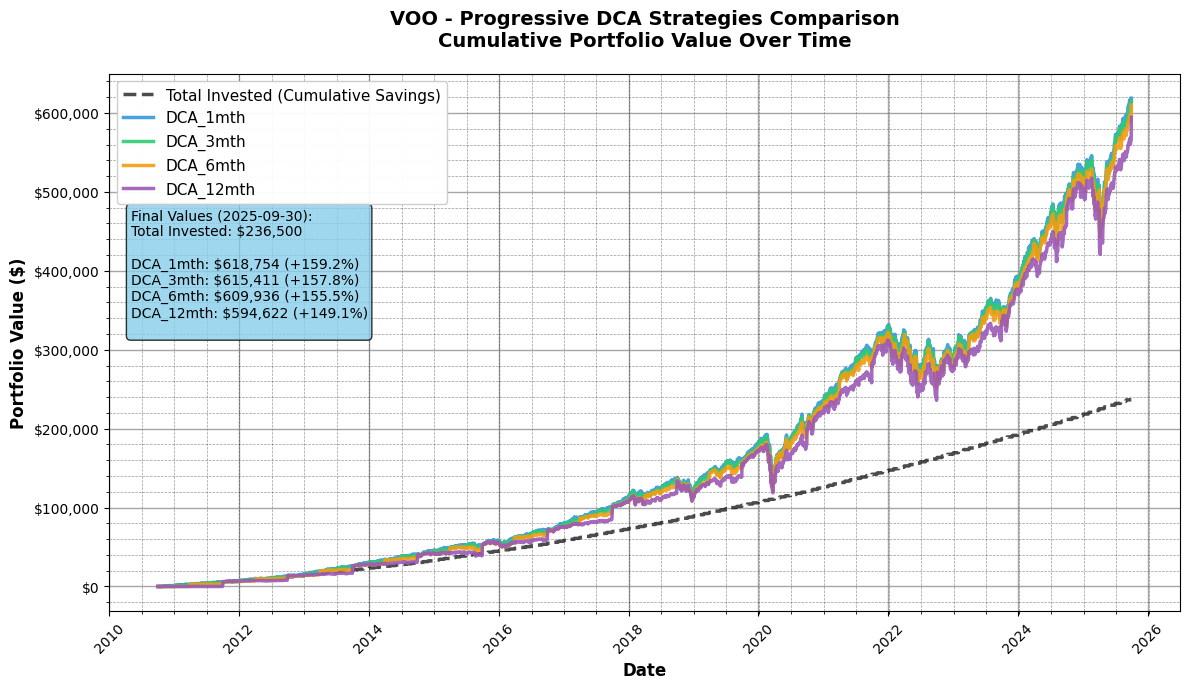

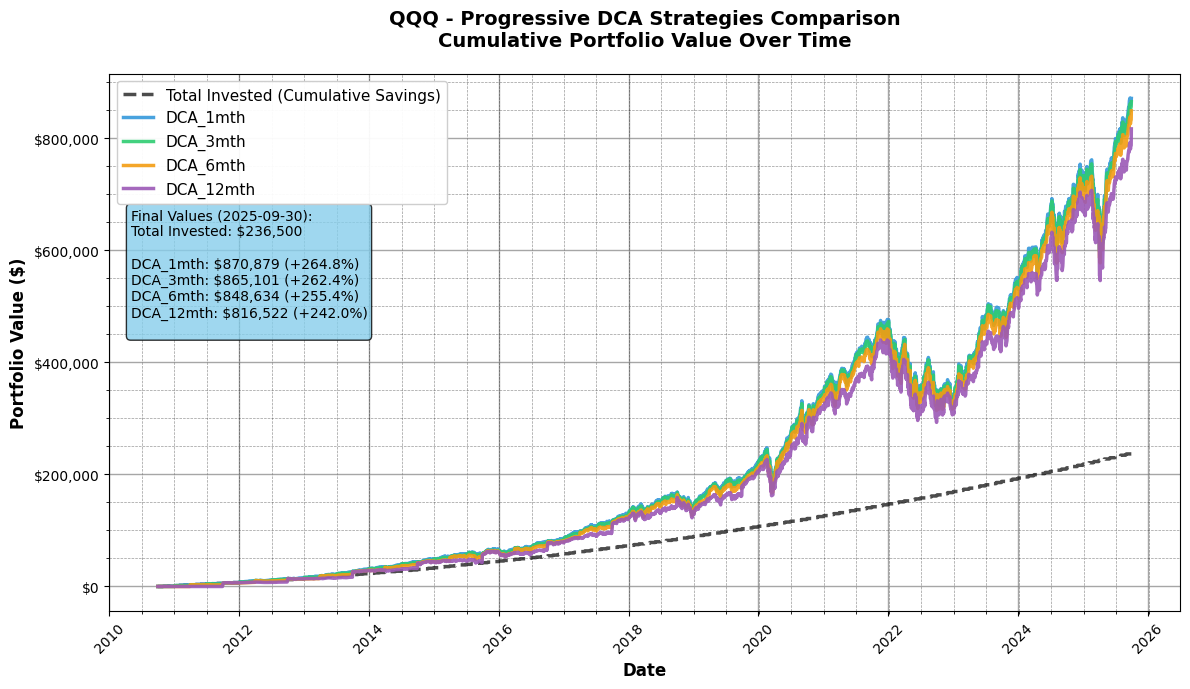

In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')

def find_nearest_trading_day(target_date, data_index, direction="nearest"):
    """Find nearest valid trading day from data index."""
    target_date = pd.to_datetime(target_date)
    if direction == "before":
        available = data_index[data_index <= target_date]
        return available[-1] if len(available) > 0 else data_index[0]
    elif direction == "after":
        available = data_index[data_index >= target_date]
        return available[0] if len(available) > 0 else data_index[-1]
    else:
        differences = abs(data_index - target_date)
        return data_index[differences.argmin()]

def generate_investment_schedule(start_date, end_date, base_amount, frequency_months):
    schedule = []
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    monthly_base = 500
    increment = 250

    current_bucket = 0.0

    current_date = start_dt + relativedelta(days=1)
    months_count = 0

    while current_date <= end_dt:
        if current_date.day == 1:
            years_elapsed = ((current_date.year - start_dt.year) * 12 +
                             (current_date.month - start_dt.month)) / 12

            level = int(years_elapsed // 2)
            current_monthly_contribution = monthly_base + increment * level

            current_bucket += current_monthly_contribution
            months_count += 1

            if months_count % frequency_months == 0:
                invest_date = current_date
                schedule.append({'date': invest_date, 'amount': current_bucket})
                current_bucket = 0.0

        current_date += relativedelta(days=1)

    if current_bucket > 0:
        schedule.append({'date': end_dt, 'amount': current_bucket})

    return schedule

def get_safe_config_value(config, *keys, default=None):
    for key in keys:
        if key in config:
            return config[key]
    return default

def plot_dca_strategies(ticker, dca_results, DCA_CONFIGS, active_strategies, data, start_date, end_date):

    initial_deposit = globals().get('INITIAL_DEPOSIT', 0)

    ticker_close = data['Close'][ticker].dropna()
    ticker_open = data['Open'][ticker].dropna()
    all_dates = ticker_close.index

    colors = {
        'DCA_1mth': '#3498db',
        'DCA_2mth': '#e74c3c',
        'DCA_3mth': '#2ecc71',
        'DCA_6mth': '#f39c12',
        'DCA_12mth': '#9b59b6'
    }

    sample_dates = all_dates
    fig, ax = plt.subplots(figsize=(12, 7))

    dca_1mth_config = DCA_CONFIGS['DCA_1mth']
    dca_1mth_schedule = generate_investment_schedule(
        start_date, end_date,
        get_safe_config_value(dca_1mth_config, 'amount', default=500),
        1
    )

    cumulative_invested_series = pd.Series(
        [inv['amount'] for inv in dca_1mth_schedule],
        index=[inv['date'] for inv in dca_1mth_schedule]
    ).cumsum() + initial_deposit

    cumulative_invested_plot = cumulative_invested_series.reindex(sample_dates, method='ffill').fillna(initial_deposit)

    ax.plot(cumulative_invested_plot.index, cumulative_invested_plot.values,
            label='Total Invested (Cumulative Savings)',
            linewidth=2.5, color='black', linestyle='--', alpha=0.7)

    for strategy_name in active_strategies:

        investment_schedule = dca_results[strategy_name][ticker]['investment_schedule']

        shares_accumulated = pd.Series(dtype=float)
        current_shares = 0.0

        first_trading_day = find_nearest_trading_day(start_date, all_dates, "after")
        if initial_deposit > 0:
             if first_trading_day in ticker_open.index:
                 current_shares = initial_deposit / ticker_open.loc[first_trading_day]

        if current_shares > 0:
             shares_accumulated.loc[first_trading_day] = current_shares

        for inv in investment_schedule:
            trading_date = find_nearest_trading_day(inv['date'], all_dates, "after")

            if trading_date in ticker_open.index and trading_date > pd.to_datetime(start_date):
                buy_price = ticker_open.loc[trading_date]
                shares_bought = inv['amount'] / buy_price

                current_shares += shares_bought

                shares_accumulated.loc[trading_date] = current_shares

        shares_series = shares_accumulated.reindex(all_dates).ffill().fillna(0.0)

        portfolio_value_series = shares_series * ticker_close

        ax.plot(portfolio_value_series.index, portfolio_value_series.values,
                label=strategy_name, linewidth=2.5,
                color=colors.get(strategy_name, None), alpha=0.9)

    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    ax.set_title(f'{ticker} - Progressive DCA Strategies Comparison\nCumulative Portfolio Value Over Time',
                 fontsize=14, fontweight='bold', pad=20)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    plt.xticks(rotation=45)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='major', alpha=0.7, linestyle='-', linewidth='1', color='grey')
    ax.grid(which='minor', alpha=0.4, linestyle='--', linewidth='0.5', color='black')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)

    final_invested = cumulative_invested_plot.iloc[-1]
    textstr = f'Final Values ({sample_dates[-1].strftime("%Y-%m-%d")}):\n'
    textstr += f'Total Invested: ${final_invested:,.0f}\n\n'

    for strategy_name in active_strategies:
        final_result = dca_results[strategy_name][ticker]['summary']
        final_value = float(final_result['Final Value'].replace('$', '').replace(',', ''))
        roi = float(final_result['ROI (%)'].replace('%', ''))
        textstr += f'{strategy_name}: ${final_value:,.0f} ({roi:+.1f}%)\n'

    props = dict(boxstyle='round', facecolor='skyblue', alpha=0.8)
    ax.text(0.02, 0.75, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', bbox=props)

    plt.tight_layout()
    plt.show()

if all(v in globals() for v in ['TICKERS', 'DCA_CONFIGS', 'active_strategies', 'data', 'start_date', 'end_date', 'dca_results']):
    for ticker in TICKERS:
        plot_dca_strategies(
            ticker,
            dca_results,
            DCA_CONFIGS,
            active_strategies,
            data,
            start_date,
            end_date
        )
else:
    print("Please run the simulation script above first.")


## **15Y, DCA + Conditional (RSI/Loss-Triggered) Investment Strategy - Extended DCA**

In [ ]:
!pip install TA-Lib

**STRATEGY OVERVIEW**
- This is **an enhanced version of regular DCA investing** that combines steady, disciplined contributions with opportunistic buying during market downturns.
- Essentially it is regular DCA, but adds $2,000 extra investments when specific "discount opportunities" appear: (1) When RSI drops below 32; (2) When the stock drops 4.0% or more in a single day; (3) When the stock drops 10.0% or more over a 5-day trading week.
- WHY this strategy? NO guessing "Is this the bottom?", NO panic during crashes, NO FOMO during rallies, the rules make decisions for you.

In [ ]:
import talib
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from tabulate import tabulate
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')

TICKERS = ['VOO', 'QQQ']
base_investment_amount = 500
investment_increase = 250
increase_interval = 2
start_date = "2010-10-01"
end_date = "2025-10-01"

ENABLE_RSI_BUYING = True
ENABLE_SINGLE_DAY_DROP = False
ENABLE_WEEKLY_DROP = True

RSI_THRESHOLD = 30
RSI_PERIOD = 14
RSI_COOLING_DAYS = 5
SINGLE_DROP_THRESHOLD = -4.0
WEEKLY_DROP_THRESHOLD = -10.0

EXTRA_BUY_AMOUNT_START = 1000
EXTRA_BUY_INCREASE = 1000
EXTRA_BUY_INTERVAL = 5

INITIAL_DEPOSIT = 0
FIRST_SCHEDULED_INVESTMENT_DATE = (pd.to_datetime(start_date) + relativedelta(months=1)).strftime("%Y-%m-%d")


print("Conditional Investment Strategy Simulation")
print("-" * 60)

print(f"\nEXTRA BUYING CONDITIONS:")
print(f"\t· RSI Buying      : {'Enabled' if ENABLE_RSI_BUYING else 'Disabled'} (RSI < {RSI_THRESHOLD}, {RSI_COOLING_DAYS} days cooling)")
print(f"\t· Single Day Drop : {'Enabled' if ENABLE_SINGLE_DAY_DROP else 'Disabled'} (Drop ≤ {SINGLE_DROP_THRESHOLD}%)")
print(f"\t· Weekly Drop     : {'Enabled' if ENABLE_WEEKLY_DROP else 'Disabled'} (Drop ≤ {WEEKLY_DROP_THRESHOLD}%)")
print(f"\t· Extra Buy Amount: Starts at ${EXTRA_BUY_AMOUNT_START:,}, increases by ${EXTRA_BUY_INCREASE:,} every {EXTRA_BUY_INTERVAL} years\n")

data = yf.download(TICKERS, start=start_date, end=end_date, interval='1d', progress=False)[['Open', 'Close']]
data = data.sort_index()

def calculate_rsi(prices, period=14):
    rsi = talib.RSI(prices.values, timeperiod=period)
    return pd.Series(rsi, index=prices.index)

def find_nearest_trading_day(target_date, data_index, direction="nearest"):
    target_date = pd.to_datetime(target_date)
    if direction == "before":
        available = data_index[data_index <= target_date]
        return available[-1] if len(available) > 0 else data_index[0]
    elif direction == "after":
        available = data_index[data_index >= target_date]
        return available[0] if len(available) > 0 else data_index[-1]
    else:
        differences = abs(data_index - target_date)
        return data_index[differences.argmin()]

def generate_investment_schedule(start_date_employment, end_date, base_amount, increase_amount, increase_interval):
    schedule = []
    # The first scheduled investment is one month after employment start_date
    current_date = pd.to_datetime(start_date_employment) + relativedelta(months=1)
    end_dt = pd.to_datetime(end_date)
    start_dt = pd.to_datetime(start_date_employment)

    while current_date <= end_dt:
        years_elapsed = (current_date - start_dt).days / 365.25

        increases_applied = int(years_elapsed // increase_interval)
        current_amount = base_amount + (increases_applied * increase_amount)

        schedule.append({
            'date': current_date,
            'amount': current_amount,
            'year': current_date.year,
            'years_elapsed': years_elapsed
        })

        current_date += relativedelta(months=1)

    return schedule

investment_schedule = generate_investment_schedule(start_date, end_date, base_investment_amount,
                                                     investment_increase, increase_interval)

print("Investment Schedule Summary:")
print("-" * 60)
current_amount = base_investment_amount
total_years = pd.to_datetime(end_date).year - pd.to_datetime(start_date).year
start_year_for_print = pd.to_datetime(FIRST_SCHEDULED_INVESTMENT_DATE).year
for year in range(start_year_for_print, pd.to_datetime(end_date).year + 1, increase_interval):
    end_year = min(year + increase_interval - 1, pd.to_datetime(end_date).year)
    print(f"Years {year}-{end_year}: ${current_amount:,} every 2 months")
    current_amount += investment_increase

investment_logs = {}
summary_results = {}

for ticker in TICKERS:
    log = []
    total_shares = 0.0
    total_invested = 0.0
    total_scheduled_invested = 0.0
    extra_buys_count = 0
    scheduled_investments_count = 0

    ticker_open = data['Open'][ticker].dropna()
    ticker_close = data['Close'][ticker].dropna()
    all_dates = ticker_open.index

    rsi_values = calculate_rsi(ticker_close, RSI_PERIOD).dropna() if ENABLE_RSI_BUYING else pd.Series(dtype=float)

    daily_returns = ticker_close.pct_change() * 100 if ENABLE_SINGLE_DAY_DROP else pd.Series(dtype=float)

    weekly_returns = ticker_close.pct_change(periods=5) * 100 if ENABLE_WEEKLY_DROP else pd.Series(dtype=float)

    total_daily_drops = len(daily_returns[daily_returns <= SINGLE_DROP_THRESHOLD]) if ENABLE_SINGLE_DAY_DROP else 0
    total_weekly_drops = len(weekly_returns[weekly_returns <= WEEKLY_DROP_THRESHOLD]) if ENABLE_WEEKLY_DROP else 0

    last_rsi_buy_date = None
    extra_buy_dates = []

    all_trading_dates = sorted(all_dates)

    if INITIAL_DEPOSIT > 0:
        inv_date = pd.to_datetime(start_date)
        trading_date = find_nearest_trading_day(inv_date, all_dates, "after")
        buy_price = ticker_open.loc[trading_date]
        shares = INITIAL_DEPOSIT / buy_price
        total_shares += shares
        total_invested += INITIAL_DEPOSIT
        avg_price = total_invested / total_shares
        current_close = ticker_close.loc[trading_date]
        portfolio_value = total_shares * current_close
        unrealized_pl = portfolio_value - total_invested
        cum_return = (unrealized_pl / total_invested) * 100 if total_invested > 0 else 0

        log.append({
            "Date": trading_date.strftime("%Y-%m-%d"),
            "Type": "Init",
            "Investment ($)": f"{INITIAL_DEPOSIT:,}",
            "Price ($)": f"{buy_price:.2f}",
            "Shares Acquired": f"{shares:.4f}",
            "Total Shares": f"{total_shares:.4f}",
            "Total Invested ($)": f"{total_invested:,.2f}",
            "Average Price ($)": f"{avg_price:.2f}",
            "Portfolio Value ($)": f"{portfolio_value:,.2f}",
            "Unrealized P/L ($)": f"{unrealized_pl:,.2f}",
            "Cumulative Return (%)": f"{cum_return:.2f}%",
            "Condition": "Initial Deposit"
        })

    scheduled_dates = []
    for investment in investment_schedule:
        inv_date = investment['date']
        investment_amount = investment['amount']

        trading_date = find_nearest_trading_day(inv_date, all_dates, "after")
        scheduled_dates.append(trading_date)

        buy_price = ticker_open.loc[trading_date]

        shares = investment_amount / buy_price
        total_shares += shares
        total_invested += investment_amount
        total_scheduled_invested += investment_amount
        scheduled_investments_count += 1

        avg_price = total_invested / total_shares

        current_close = ticker_close.loc[trading_date]
        portfolio_value = total_shares * current_close
        unrealized_pl = portfolio_value - total_invested
        cum_return = (unrealized_pl / total_invested) * 100 if total_invested > 0 else 0

        log.append({
            "Date": trading_date.strftime("%Y-%m-%d"),
            "Type": "RSP",
            "Investment ($)": f"{investment_amount:,}",
            "Price ($)": f"{buy_price:.2f}",
            "Shares Acquired": f"{shares:.4f}",
            "Total Shares": f"{total_shares:.4f}",
            "Total Invested ($)": f"{total_invested:,.2f}",
            "Average Price ($)": f"{avg_price:.2f}",
            "Portfolio Value ($)": f"{portfolio_value:,.2f}",
            "Unrealized P/L ($)": f"{unrealized_pl:,.2f}",
            "Cumulative Return (%)": f"{cum_return:.2f}%",
            "Condition": "Regular DCA"
        })

    def get_extra_buy_amount(current_date, start_date_employment):
        start_dt = pd.to_datetime(start_date_employment)
        current_dt = pd.to_datetime(current_date)
        years_elapsed = (current_dt - start_dt).days / 365.25
        increases = int(years_elapsed // EXTRA_BUY_INTERVAL)
        return EXTRA_BUY_AMOUNT_START + (increases * EXTRA_BUY_INCREASE)

    for current_date in all_trading_dates:
        if INITIAL_DEPOSIT > 0 and current_date == pd.to_datetime(find_nearest_trading_day(start_date, all_dates, "after")):
            if current_date in scheduled_dates:
                continue

        if current_date in scheduled_dates:
            continue

        current_extra_buy_amount = get_extra_buy_amount(current_date, start_date)
        current_close = ticker_close.loc[current_date]
        buy_triggered = False
        buy_reason = ""

        if (ENABLE_RSI_BUYING and
            current_date in rsi_values.index and
            not pd.isna(rsi_values.loc[current_date]) and
            rsi_values.loc[current_date] < RSI_THRESHOLD):

            if (last_rsi_buy_date is None or
                (current_date - last_rsi_buy_date).days >= RSI_COOLING_DAYS):
                buy_triggered = True
                buy_reason = f"RSI < {RSI_THRESHOLD} ({rsi_values.loc[current_date]:.1f})"
                last_rsi_buy_date = current_date

        if (not buy_triggered and ENABLE_SINGLE_DAY_DROP and
            current_date in daily_returns.index and
            not pd.isna(daily_returns.loc[current_date]) and
            daily_returns.loc[current_date] <= SINGLE_DROP_THRESHOLD):
            buy_triggered = True
            buy_reason = f"Daily drop ({daily_returns.loc[current_date]:.1f}%)"

        if (not buy_triggered and ENABLE_WEEKLY_DROP and
            current_date in weekly_returns.index and
            not pd.isna(weekly_returns.loc[current_date]) and
            weekly_returns.loc[current_date] <= WEEKLY_DROP_THRESHOLD):
            buy_triggered = True
            buy_reason = f"Weekly drop ({weekly_returns.loc[current_date]:.1f}%)"

        if buy_triggered:
            shares = current_extra_buy_amount / current_close
            total_shares += shares
            total_invested += current_extra_buy_amount
            extra_buys_count += 1
            extra_buy_dates.append(current_date)

            avg_price = total_invested / total_shares
            portfolio_value = total_shares * current_close
            unrealized_pl = portfolio_value - total_invested
            cum_return = (unrealized_pl / total_invested) * 100 if total_invested > 0 else 0

            log.append({
                "Date": current_date.strftime("%Y-%m-%d"),
                "Type": "Extra",
                "Investment ($)": f"{current_extra_buy_amount:,}",
                "Price ($)": f"{current_close:.2f}",
                "Shares Acquired": f"{shares:.4f}",
                "Total Shares": f"{total_shares:.4f}",
                "Total Invested ($)": f"{total_invested:,.2f}",
                "Average Price ($)": f"{avg_price:.2f}",
                "Portfolio Value ($)": f"{portfolio_value:,.2f}",
                "Unrealized P/L ($)": f"{unrealized_pl:,.2f}",
                "Cumulative Return (%)": f"{cum_return:.2f}%",
                "Condition": buy_reason
            })

    investment_logs[ticker] = pd.DataFrame(log).sort_values('Date').reset_index(drop=True)

    final_date = find_nearest_trading_day(end_date, all_dates, "before")
    last_price = ticker_close.loc[final_date]
    final_portfolio_value = total_shares * last_price
    total_returns = final_portfolio_value - total_invested
    roi_percentage = (total_returns / total_invested) * 100 if total_invested > 0 else 0
    avg_price = total_invested / total_shares if total_shares > 0 else 0

    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    years = (end_dt - start_dt).days / 365.25

    summary_results[ticker] = {
        'Scheduled Investments': scheduled_investments_count,
        'Extra Buys': extra_buys_count,
        'Total Scheduled Invested ($)': f"{total_scheduled_invested:,.2f}",
        'Total Invested ($)': f"{total_invested:,.2f}",
        'Total Shares': f"{total_shares:.4f}",
        'Average Price ($)': f"{avg_price:.2f}",
        'Final Price ($)': f"{last_price:.2f}",
        'Final Portfolio Value ($)': f"{final_portfolio_value:,.2f}",
        'Total Returns ($)': f"{total_returns:,.2f}",
        'ROI (%)': f"{roi_percentage:.2f}%",
        'Years': years,
        'Total Daily Drops': total_daily_drops,
        'Total Weekly Drops': total_weekly_drops
    }

print("\n" + "="*60)
print("CONDITIONAL INVESTMENT SIMULATION RESULTS")
print("="*60)

for ticker in TICKERS:
    print(f"\n{ticker} - Detailed Investment Log:")
    print("-" * 60)
    df = investment_logs[ticker]

    print("First 10 investments:")
    print(df.head(10).to_string(index=False))

    if len(df) > 20:
        print("...")
        print("Last 10 investments:")
        print(df.tail(10).to_string(index=False))
        print("")

    extra_buys = df[df['Type'] == 'Extra']
    if len(extra_buys) > 0:
        print(f"Extra Buys Summary for {ticker} ({len(extra_buys)} total):")
        print("-" * 60)

        rsi_buys = len(extra_buys[extra_buys['Condition'].str.contains('RSI', na=False)])
        single_drop_buys = len(extra_buys[extra_buys['Condition'].str.contains('Daily drop', na=False)])
        weekly_drop_buys = len(extra_buys[extra_buys['Condition'].str.contains('Weekly drop', na=False)])

        total_extra_invested = sum([float(str(amount).replace(',', '')) for amount in extra_buys['Investment ($)']])


        if rsi_buys > 0:
            rsi_invested = sum([float(str(amount).replace(',', '')) for amount in extra_buys[extra_buys['Condition'].str.contains('RSI', na=False)]['Investment ($)']])
            print(f"  RSI < {RSI_THRESHOLD} (RSI Buy): {rsi_buys} buys (${rsi_invested:,.2f})")
        if single_drop_buys > 0:
            single_drop_invested = sum([float(str(amount).replace(',', '')) for amount in extra_buys[extra_buys['Condition'].str.contains('Daily drop', na=False)]['Investment ($)']])
            print(f"  Daily Drop ≤ {SINGLE_DROP_THRESHOLD}%: {single_drop_buys} buys (${single_drop_invested:,.2f})")
        if weekly_drop_buys > 0:
            weekly_drop_invested = sum([float(str(amount).replace(',', '')) for amount in extra_buys[extra_buys['Condition'].str.contains('Weekly drop', na=False)]['Investment ($)']])
            print(f"  Weekly Drop ≤ {WEEKLY_DROP_THRESHOLD}%: {weekly_drop_buys} buys (${weekly_drop_invested:,.2f})\n")

summary_df = pd.DataFrame(summary_results).T
print(f"\n{tabulate(summary_df.drop(columns=['Years', 'Total Daily Drops', 'Total Weekly Drops']), headers='keys', tablefmt='pipe', showindex=False)}\n")

print(f"\n{'='*60}")
print("PERFORMANCE COMPARISON")
print("="*60)

for ticker in TICKERS:
    scheduled_invested = float(summary_results[ticker]['Total Scheduled Invested ($)'].replace(',', ''))
    total_invested = float(summary_results[ticker]['Total Invested ($)'].replace(',', ''))
    final_value = float(summary_results[ticker]['Final Portfolio Value ($)'].replace(',', ''))
    roi = float(summary_results[ticker]['ROI (%)'].replace('%', ''))
    years = summary_results[ticker]['Years']
    extra_invested = total_invested - scheduled_invested - INITIAL_DEPOSIT

    first_investment_date = pd.to_datetime(start_date) if INITIAL_DEPOSIT > 0 else pd.to_datetime(FIRST_SCHEDULED_INVESTMENT_DATE)
    end_dt = pd.to_datetime(end_date)
    years_for_cagr = (end_dt - first_investment_date).days / 365.25

    if total_invested > 0 and years_for_cagr > 0:
        cagr = ((final_value/total_invested)**(1/years_for_cagr) - 1)*100
    else:
        cagr = 0.0

    print(f"{ticker}:")
    print(f"· Scheduled Invested: ${scheduled_invested:,.2f}")
    print(f"· Initial Deposit   : ${INITIAL_DEPOSIT:,.2f}")
    print(f"· Extra Invested    : ${extra_invested:,.2f}")
    print(f"· Total Invested    : ${total_invested:,.2f}")
    print(f"· Final Value       : ${final_value:,.2f}")
    print(f"· Total Return      : {roi:.2f}%")
    print(f"· Portfolio CAGR    : {cagr:.2f}% (over {years_for_cagr:.2f} years)\n")

print(f"\nInvestment period: {len(investment_schedule)} scheduled investments over {years:.2f} years\n")

print(f"===== Activated Extra Buy Conditions =====")
if ENABLE_RSI_BUYING:
    print(f" · RSI buying when RSI(14) < {RSI_THRESHOLD} (Cooling: {RSI_COOLING_DAYS} days)")
if ENABLE_SINGLE_DAY_DROP:
    print(f" · Single Day Drop ≤ {SINGLE_DROP_THRESHOLD}%")
if ENABLE_WEEKLY_DROP:
    print(f" · Weekly Drop ≤ {WEEKLY_DROP_THRESHOLD}%")
if not any([ENABLE_RSI_BUYING, ENABLE_SINGLE_DAY_DROP, ENABLE_WEEKLY_DROP]):
    print(f" · NONE (all disabled)")

Conditional Investment Strategy Simulation
------------------------------------------------------------

EXTRA BUYING CONDITIONS:
	· RSI Buying      : Enabled (RSI < 30, 5 days cooling)
	· Single Day Drop : Disabled (Drop ≤ -4.0%)
	· Weekly Drop     : Enabled (Drop ≤ -10.0%)
	· Extra Buy Amount: Starts at $1,000, increases by $1,000 every 5 years

Investment Schedule Summary:
------------------------------------------------------------
Years 2010-2011: $500 every 2 months
Years 2012-2013: $750 every 2 months
Years 2014-2015: $1,000 every 2 months
Years 2016-2017: $1,250 every 2 months
Years 2018-2019: $1,500 every 2 months
Years 2020-2021: $1,750 every 2 months
Years 2022-2023: $2,000 every 2 months
Years 2024-2025: $2,250 every 2 months

CONDITIONAL INVESTMENT SIMULATION RESULTS

VOO - Detailed Investment Log:
------------------------------------------------------------
First 10 investments:
      Date Type Investment ($) Price ($) Shares Acquired Total Shares Total Invested ($) Avera

**Interpretation:**
- The outcomes are far more better than Regular DCA.
- For QQQ, despite the ROI is almost the same, but this loss-triggered strategy has a greater total invested amount, pushing the final portfolio value up to USD 1.152 million from initial USD 870k.